## MAIO HAND IN 2 - REMOTE SENSING - 
### Empirical Orthogonal Function (EOF) Analysis
### Option 3: Ocean Circulation in the North Atlantic
#### Athina Karaoli, Anna de Vries, Foteini Stavropoulou

### 1. Reading and plotting the data

As a first step following what we did in the practical, we’ll make a plot of the data for May 2020 (month 325)

In [44]:
import numpy as np
from numpy import ma
import netCDF4 as ncdf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import sklearn
import cartopy # for the coastlines
import cartopy.crs as ccrs  
import cartopy.feature as cfeature

In [45]:
# Import data from file
filepath = "C:/Users/athen/PythonMasterProject/MAIO/handin2/Final/MAIO_hand_in_2_Athina_Anna_Foteini/"  # this should be the path where you stored the netcdf file

# read the data and put in arrays
data = ncdf.Dataset(filepath+"dt_natl_allsat_msla_h_y1993_2020_05deg_detrended.nc", mode='r')
#print(data.variables)

lat = data.variables["lat"][:]    # number of lat: 100 /// from 20.25 until 69.75 with 0.5 step
lon = data.variables["lon"][:]    # number of lon: 181 /// from -90 until 0 with 0.5 step
time = data.variables["time"][:]  # number of months: 326 /// from 1993 until 2020 /// units: year.fraction_of_year
                                  # time is given in decimal representation (e.g. 2003.044 equals 16 January 2003) 
    
sla = data.variables["sla"][:,::-1,:] # sla stands for sea surface height anomalies (time, lat, lon) = (326, 100, 181)
nt = sla.shape[0] # number of months: 326 

data.close()

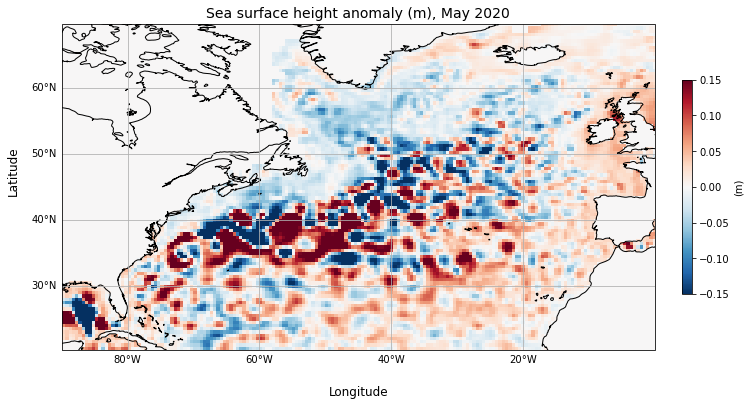

In [46]:
#Plot the sea surface height anomalies for May 2020 (month #325)

#set up the figure
fig, ax = plt.subplots(1,1,figsize=(12,6))

# add coastlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# plot the data
im = ax.imshow(sla[325,:,:], vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])

# Set colorbar, the labels of the axis and the title
plt.colorbar(im,fraction=0.016, pad=0.04, label = "(m)")
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',           
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.set_title(r'Sea surface height anomaly (m), May 2020', fontsize=14)

# add gridlines with lat and lon
ax.set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

# save figure
#plt.savefig(filepath+"SLAMay2020.png", bbox_inches='tight')
plt.show()


### Create the map showing the standard deviation of the signal ( Introduction ) 

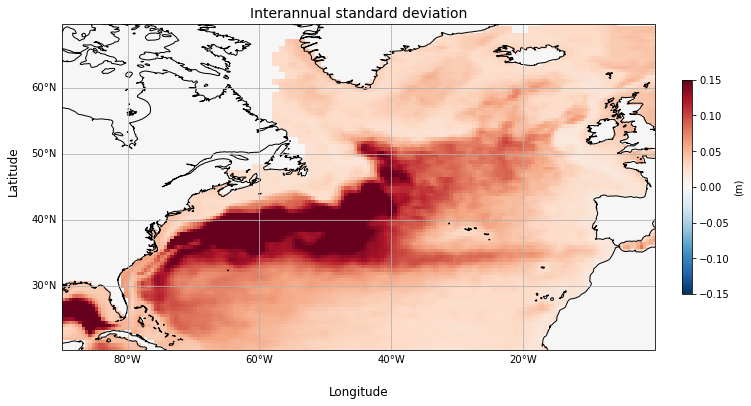

In [47]:
sigma = np.std(sla, axis=0)   
#print(sigma.shape)            # size: (100,181)

#set up the figure
fig, ax = plt.subplots(1,1,figsize=(12,6))

# add coastlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# plot the data
im = ax.imshow(sigma, vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])

# Set colorbar, the labels of the axis and the title
plt.colorbar(im,fraction=0.016, pad=0.04, label = "(m)")
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.set_title(r'Interannual standard deviation', fontsize=14)

# add gridlines with lat and lon
ax.set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

# save figure
#plt.savefig(filepath+"standard.png", bbox_inches='tight')
plt.show()

#	2. Covariance matrix, eigenvectors and plotting the results
First, prepare the data matrix X by putting all the 100*181 observations for each of the 326 months in one column (for example, using np.reshape)

Compute the covariance matrix from the data matrix X. Remember to remove the mean from the data! The covariance matrix will be a very large matrix. Therefore, we can work with the transpose of X (so, XT), which will result in a much smaller covariance matrix. 

We then compute the total variance of data set by summing the elements on the diagonal of the covariance matrix.

In [48]:
# Reshape the grid to a 2-D matrix with the rows corresponding to time and columns to position 
X = np.reshape(sla, (sla.shape[0], len(lat) * len(lon)), order='F')
print("Size of X:",X.shape)
# we get Size of X: (326, 18100)

### Work with the transpose of the matrix to avoid memory problems when computing the covariance matrix
# EXPLANATION: it's because the covariance matrix is computed by multiplying the data matrix with it's own transpose
# so if you do that with a 18100x326, you'll get a 18100 x 18100 matrix
# if you use the transpose of the data matrix it's (326, 326)
X=X.T

#Subtract the column mean 
meandata = (X.mean(axis=0))
X = X - meandata            # in the slides this is written as X'

### compute the covariance matrix as the product of X^T and X
covdat = np.dot(X.T,X)/(nt-1)       

### check size of the covariance matrix
print("Size of covariance matrix:",covdat.shape) # ---> (326, 326)

# we use trace() function used to Sum along diagonals.
result =  np.trace(covdat)               
print("Total variance of data:",result)  

Size of X: (326, 18100)
Size of covariance matrix: (326, 326)
Total variance of data: 71.46753406524658


Next, we compute the eigenvalues and eigenvectors (e.g. using np.linalg.eig) and check that the sum of eigenvalues equals the total variance of the data (computed in the previous step)

In [49]:
# compute the eigenvalues (vals) and eigenvectors (vecs)
vals, vecs = np.linalg.eig(covdat)     
# size of vals: 326
# size of vecs: (326, 326)

# sort the eigenvalues
isort = np.argsort(vals)[::-1]   
# size: 326                     

vals = vals[isort]   # so now we actually put the in order
PCs = vecs[:, isort] # re-arrange the columns 
                     # By ranking our eigenvectors in order of their eigenvalues, highest to lowest,
                     # we get the principal components in order of significance

# print first 10 eigenvalues
print("Eigenvalues are:\n", vals[0:10])  

# check if sum of eigenvalues equals total variance in covariance matrix. 
print("Sum of eigenvalues is:\n", sum(vals))  

Eigenvalues are:
 [4.1644993 2.234791  1.9204804 1.8106742 1.720907  1.6169256 1.4724556
 1.3848809 1.3021207 1.2435774]
Sum of eigenvalues is:
 71.46753407745388


Plot the results (both loadings and scores). Which  processes are represented by these three modes? (Note: when working with the transpose of X, keep in mind that the loadings are now the scores, and vice versa).

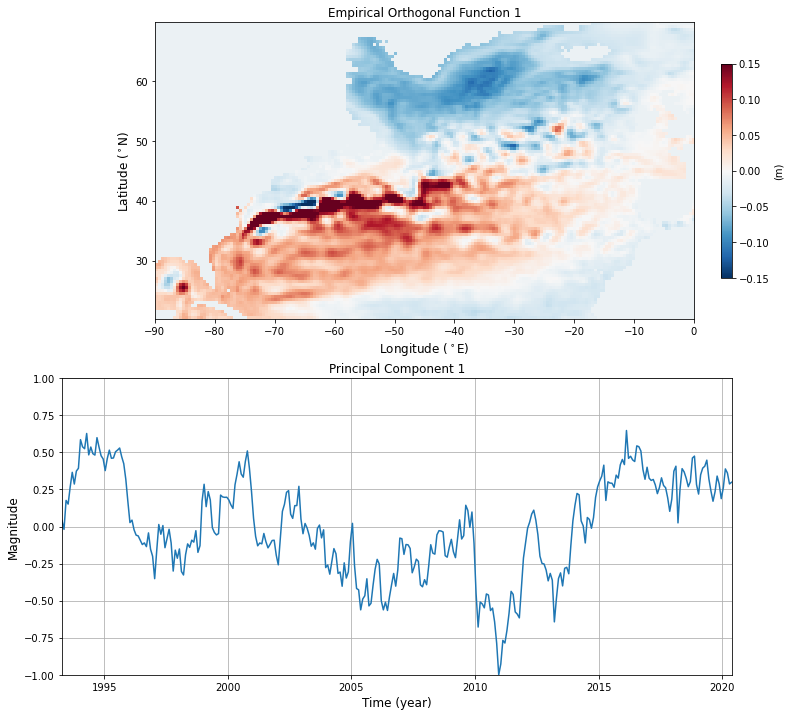

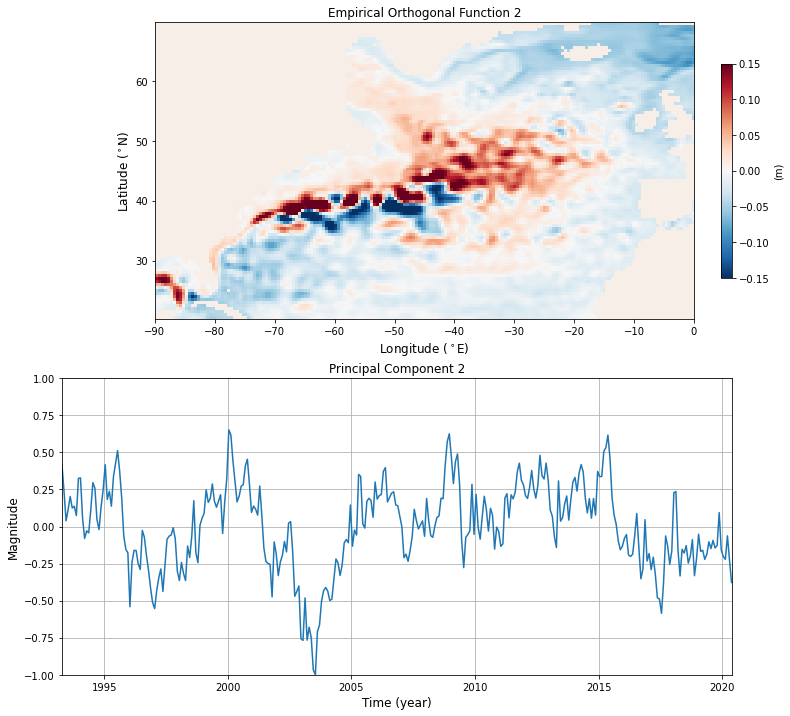

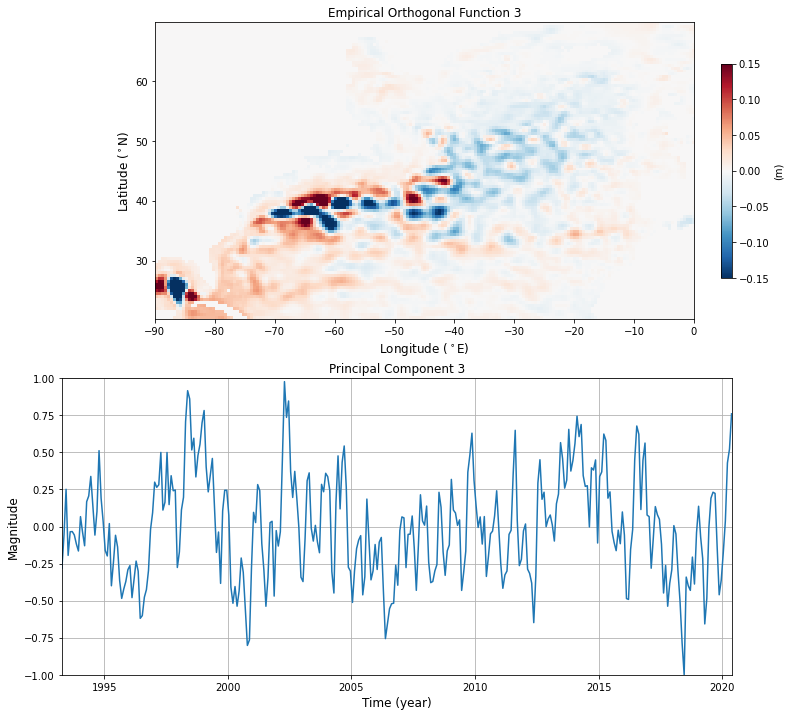

In [50]:
t = np.linspace(0, 1, nt)
EOFs = np.dot(X,vecs)  # projection on new basis/ new axis system ---> size: (18100, 326) 

# rearrange the loadings back to lat x lon array
EOF_recons = np.reshape(EOFs.T, (nt, len(lat), len(lon)), order='F')   # basically we go back to the original form of the data
# size: (326, 100, 181)

# plot loadings and scores
for j in range(0,3):   # first three modes LECTURE 6 SLIDE 36
    
     scaled_EOF = EOF_recons[j,:,:]*max(abs(PCs[:,j]))  
       
     fig, ax = plt.subplots(2,1,figsize=(12,12))
     im = ax[0].imshow(scaled_EOF, vmin=-0.15, vmax = 0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
     cbar=plt.colorbar(im,fraction=0.016, pad=0.04,ax=ax[0])
     cbar.set_label('(m)')
     ax[0].set_xlabel(r'Longitude ($^\circ$E)', fontsize=12)
     ax[0].set_ylabel(r'Latitude ($^\circ$N)', fontsize=12)
     eof=j+1
     ax[0].set_title(r'Empirical Orthogonal Function %i' % eof)
    
     # The division of the PC by it’s maximum value is to ensure that the maximum value of the PC
     # time series is equal to 1 (or -1). This step isn’t absolutely necessary, but makes 
     # it easer to compare the different modes. Because the product of EOF*PC shouldn’t change, 
     # the inverse scaling needs to be applied to the EOF. 
        
     PCnor = PCs[:,j]/max(abs(PCs[:,j])) 
    
     ax[1].plot(time,PCnor)
     ax[1].grid()
     ax[1].set_title('Principal Component %i' % eof)
     ax[1].set_xlabel('Time (year)', fontsize=12)
     ax[1].set_ylabel('Magnitude', fontsize=12)
     ax[1].set_xlim([time[0],time[-1]])
     ax[1].set_ylim([-1,1])
        
     plt.show()

### A map of the first EOF, together with a plot of the time series of the associated EOF coefficients ( Results )

In [51]:
sla_time=np.mean(sla,axis=(1, 2))   

#sla_time = sla.mean(axis=(1,2), dtype=np.float64)
#sla_time = sla.mean(axis=1).mean(axis=1)
#sla_time = sla.sum(axis=2).sum(axis=1) / np.prod(sla.shape[1:3])
sla_time=sla_time/max(abs(sla_time))
#print(sla_time)
sla_time.shape

(326,)

In [52]:
scaled_EOF = EOF_recons[0,:,:]*max(abs(PCs[:,0])) 
PCnor = PCs[:,0]/max(abs(PCs[:,0])) 
PCnor1 = PCs[:,1]/max(abs(PCs[:,1]))
PC = PCnor + PCnor1
print(PCnor[1], PCnor1[1], PC[1])

-0.019043598 0.23841089 0.2193673


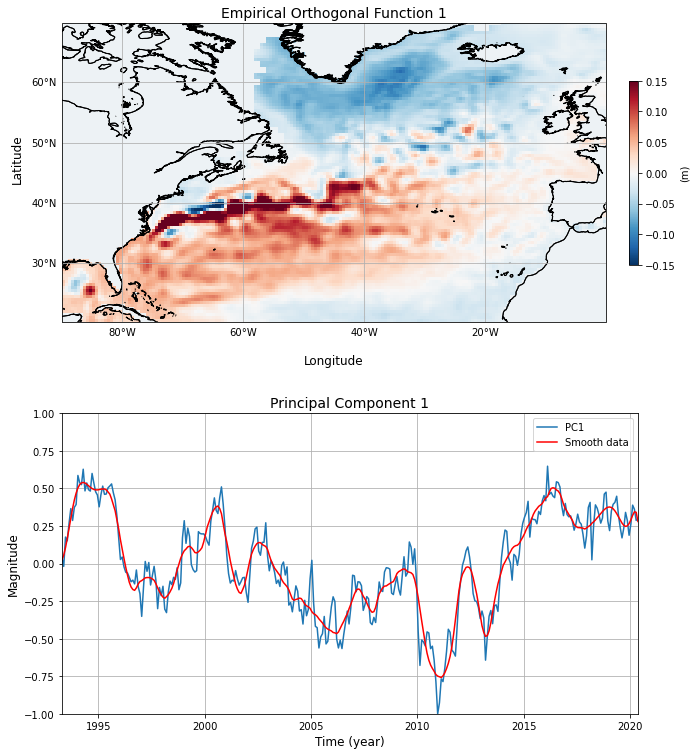

In [53]:
scaled_EOF = EOF_recons[0,:,:]*max(abs(PCs[:,0])) 
PCnor = PCs[:,0]/max(abs(PCs[:,0])) 
#PCnor1 = PCs[:,1]/max(abs(PCs[:,1]))
#PC = PCs[:,0] + PCs[:,1]
#PC=PC/max(abs(PC))

#set up the figure
#fig, ax = plt.figure(figsize=(10,12))
fig = plt.figure(figsize=(10,12))

# first subplot EOF1
ax[0] = fig.add_subplot(2,1,1,projection=ccrs.PlateCarree())
ax[0].imshow(scaled_EOF, vmin=-0.2*np.amax(abs(scaled_EOF)), vmax = 0.2*np.amax(abs(scaled_EOF)), cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])

# add coastlines
ax[0].coastlines(resolution='50m')
ax[0].add_feature(cfeature.LAND)

# add colorbar, labels to the axis and title
cbar=plt.colorbar(im,fraction=0.016, pad=0.04,ax=ax[0])
cbar.set_label('(m)')
ax[0].text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[0].transAxes)
ax[0].text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax[0].transAxes)
ax[0].set_title(r'Empirical Orthogonal Function 1', fontsize=14)

# add gridlines with lat and lon
ax[0].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
ax[0].coastlines(resolution='10m')
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

# second subplot PC1
ax[1] = fig.add_subplot(2,1,2)
ax[1].plot(time,PCnor, label='PC1')

# 1
from scipy.signal import savgol_filter
yhat = savgol_filter(PCnor, 51, 9) # window size 51, polynomial order 3
ax[1].plot(time,yhat, color='red', label='Smooth data')

# 2
#mymodel = np.poly1d(np.polyfit(time, PCnor, 14))
#t = np.linspace(1993, 2020, 27)
#ax[1].plot(t, mymodel(t))

#3 
#def smooth(y, box_pts):
#    box = np.ones(box_pts)/box_pts
#    y_smooth = np.convolve(y, box, mode='same')
#    return y_smooth

#ax[1].plot(time, smooth(PCnor,3), 'r-', lw=2)
#ax[1].plot(time, smooth(PCnor,19), 'r-', lw=2)

# title, labels, axis limits and grid
ax[1].set_title('Principal Component 1', fontsize=14)
ax[1].set_xlabel('Time (year)',fontsize=12,)
ax[1].set_ylabel('Magnitude',fontsize=12,)
ax[1].set_xlim([time[0],time[-1]])
ax[1].set_ylim([-1,1])
ax[1].legend()
ax[1].grid()

# adjust the space between the two subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

# save figure
#plt.savefig(filepath+"EOFandPC 1.png", bbox_inches='tight')
plt.show()          

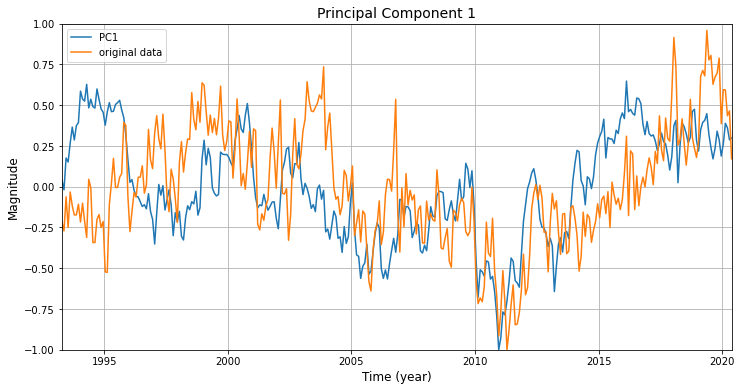

In [54]:

#set up the figure
fig, ax = plt.subplots(1,1,figsize=(12,6))

# second subplot PC1
ax.plot(time,PCnor, label='PC1')
ax.plot(time,sla_time, label='original data')

# title, labels, axis limits and grid
ax.set_title('Principal Component 1', fontsize=14)
ax.set_xlabel('Time (year)',fontsize=12,)
ax.set_ylabel('Magnitude',fontsize=12,)
ax.set_xlim([time[0],time[-1]])
ax.set_ylim([-1,1])
ax.legend()
ax.grid()


# save figure
#plt.savefig(filepath+"PC1.png", bbox_inches='tight')
plt.show()   

# 3. Variance explained by each mode 
Make a plot of the fraction of explained variance by each of the modes (i.e., the eigenvalue divided by the sum of eigenvalues), and one of  cumulative fraction of explained variance of all modes. 

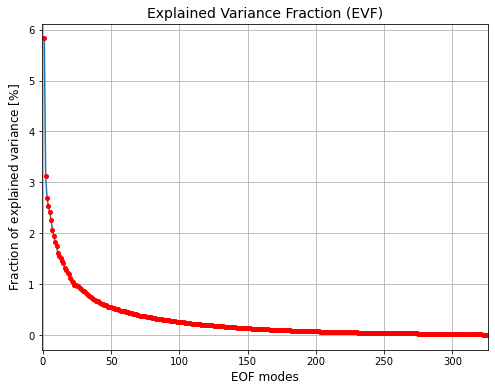

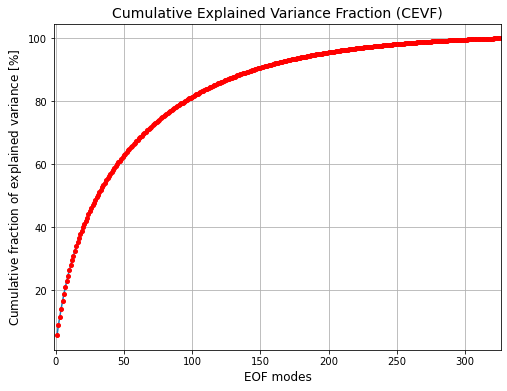

In [55]:
# Plot the fraction of explained variance of ALL MODES (EVF)
eofnumber = np.arange(1,len(vals)+1)
variance_expl = vals/np.sum(vals)*100   # to compute the percentage of variance accounted for by each
                                        # component, we divide the eigenvalue of each component by the sum of eigenvalues.

# set up the plot
f, ax = plt.subplots(figsize=(8,6))
ax.plot(eofnumber,variance_expl)
ax.plot(eofnumber,variance_expl,'ro',markersize=4)
ax.set_xlabel('EOF modes',fontsize=12)
ax.set_ylabel('Fraction of explained variance [$\%$]',fontsize=12)
ax.set_title("Explained Variance Fraction (EVF)", fontsize=14)
ax.grid()
ax.set_xlim([-1,nt])
#plt.savefig(filepath+"EVF.png", bbox_inches='tight')
plt.show()

#__________________________________________________________________________________________________________________________________________________#

# Plot the cumulative fraction of explained variance of ALL MODES
variancecumsum = np.cumsum(vals)/np.sum(vals)*100

# set up the plot
f, ax = plt.subplots(figsize=(8,6))
ax.plot(eofnumber,variancecumsum)
ax.plot(eofnumber,variancecumsum,'ro',markersize=4)
ax.set_xlabel('EOF modes',fontsize=12)
ax.set_ylabel('Cumulative fraction of explained variance [$\%$]',fontsize=12)
ax.set_title("Cumulative Explained Variance Fraction (CEVF)", fontsize=14)
ax.grid()
ax.set_xlim([-1,nt])
#plt.savefig(filepath+"CEVF.png", bbox_inches='tight')
plt.show()


## Truncation rules 

Here we have to choose how many modes we are going to keep. Therefore, we try different truncation rules based on the lecture's notes

In [56]:
# Threshold
# Lecture 6 slide 64

# Define a critical value of the total variance and retain the modes needed to pass that value
# Typically 70% ≤ CEVFcritical ≤ 90%

print("Variance contained in first 95 EOFs: % .2f" % variancecumsum[95])

Variance contained in first 95 EOFs:  80.46


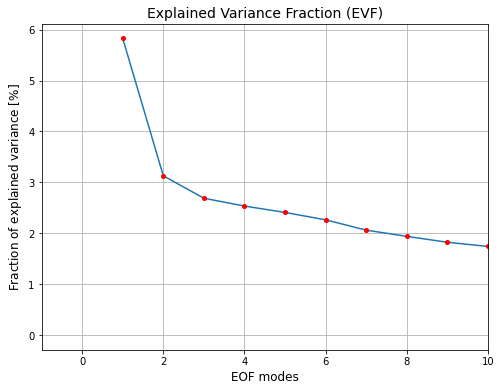

Variance contained in first 2 EOFs:  11.64


In [57]:


# Shape of eigenvalue spectrum
# Lecture 6 slide 65
# Look for a break in the slope, and truncate at the mode where this break occurs

# Plot the fraction of explained variance 
eofnumber = np.arange(1,len(vals)+1)
variance_expl = vals/np.sum(vals)*100  
                                       
# set up the plot
f, ax = plt.subplots(figsize=(8,6))
ax.plot(eofnumber,variance_expl)
ax.plot(eofnumber,variance_expl,'ro',markersize=4)
ax.set_xlabel('EOF modes',fontsize=12)
ax.set_ylabel('Fraction of explained variance [$\%$]',fontsize=12)
ax.set_title("Explained Variance Fraction (EVF)", fontsize=14)
ax.grid()
ax.set_xlim([-1,10])  # we zoom in to find the break in the slope
plt.show()

# The break in the slope happens at the second mode. So by truncating at this mode, we should keep the first two modes.
print("Variance contained in first 2 EOFs: % .2f" % variancecumsum[2])

In [58]:
# Kaiser's rule  
# Lecture 6 slide 66

mean_vals = np.mean(vals)  # mean of all eigenvalues. We get the value 0.21922556

lamda = [] # here we are going to save only the eigenvalues that satisfy our rule
k=0
T = 1

for i in range(len(vals)):
    if vals[i] > mean_vals*T:   # Only retain modes with an eigenvalue larger than the mean of all eigenvalues multiplied by T
        lamda = np.append(lamda,vals[i])  # save these eigenvalues
        k = k+1  # calculate how many modes

print("Variance contained in first 86 EOFs: % .2f"  % variancecumsum[86])

Variance contained in first 86 EOFs:  77.89


In [59]:
# Adapted Kaiser’s rule
# Lecture 6 slide 67

mean_vals = np.mean(vals)  # mean of all eigenvalues. We get the value 0.21922556

lamda = [] # here we are going to save only the eigenvalues that satisfy our rule
k=0
T = 0.7  # exactly the same method of Kaiser's but instead of 1, here T = 0.7

for i in range(len(vals)):
    if vals[i] > mean_vals*T:   # Only retain modes with an eigenvalue larger than the mean of all eigenvalues multiplied by T
        lamda = np.append(lamda,vals[i])  # save these eigenvalues
        k = k+1  # calculate how many modes

print("Variance contained in first 113 EOFs: % .2f"  % variancecumsum[113])

Variance contained in first 113 EOFs:  84.72


In [60]:
# Broken stick rule
# Lecture 6 slide 68

mean_vals = np.mean(vals)  # mean of all eigenvalues. We get the value 0.21922556

T = []  # Here T is going to be a different value for each time we check if the rule is satisfied
su = 0
ahe = np.arange(0,len(vals),1)

for j in range(1,len(vals)): # Lecture 6 slide 68  
    su = np.sum(1/ahe[j:])   # IMPORTANT: We cannot do this calculation for j=0 
    T = np.append(T,su)
    
#print(T)

aha = []
index = []
k=0

for i in range(len(vals)-1):
    if vals[i]>mean_vals*T[i]:  # Only retain modes with an eigenvalue larger than the mean of all eigenvalues multiplied by T[i]
        aha = np.append(aha,vals[i])  # save these eigenvalues 
        index = np.append(index,i)
        k = k+1 # calculate how many mode

print("Variance contained in first 55 EOFs: % .2f"  % variancecumsum[55])

Variance contained in first 55 EOFs:  65.93




### A plot of the variance explained by the eigenmodes - We choose the first 86 modes - Kaiser's rule ( Results )

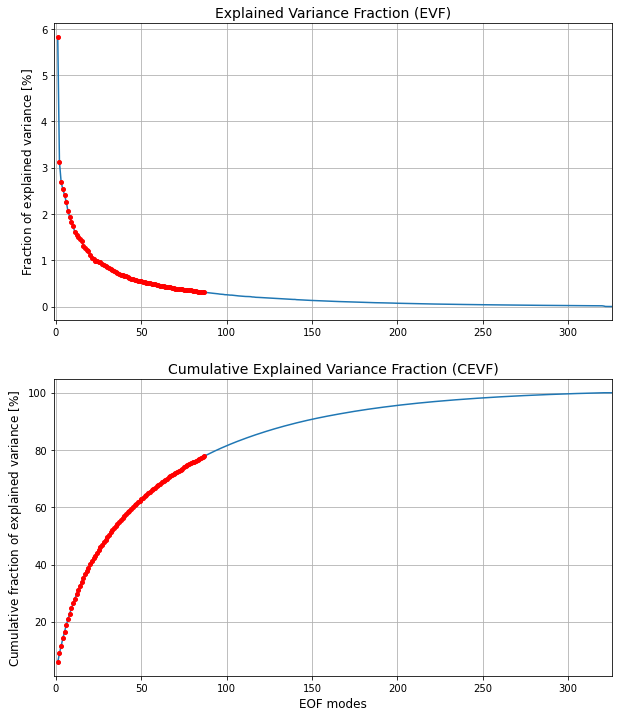

In [61]:
#Plot the fraction of explained variance of first 86 modes (EVF)
eofnumber = np.arange(1,len(vals)+1)
variance_expl = vals/np.sum(vals)*100   # to compute the percentage of variance accounted for by each
                                        # component, we divide the eigenvalue of each component by the sum of eigenvalues.

#set up the figure
#fig, axs = plt.subplots(2,1, figsize=(10,12))
fig = plt.figure(figsize=(10,12))

# first subplot 
axs[0] = fig.add_subplot(2,1,1)
axs[0].plot(eofnumber,variance_expl)
axs[0].plot(eofnumber[0:87],variance_expl[0:87],'ro',markersize=4)
axs[0].set_ylabel('Fraction of explained variance [$\%$]',fontsize=12)
axs[0].set_title("Explained Variance Fraction (EVF)", fontsize=14)
axs[0].grid()
axs[0].set_xlim([-1,nt])

#__________________________________________________________________________________________________________________________________________________#

# Plot the cumulative fraction of explained variance of first 86 modes
variancecumsum = np.cumsum(vals)/np.sum(vals)*100

# second subplot 
axs[1] = fig.add_subplot(2,1,2)
axs[1].plot(eofnumber,variancecumsum)
axs[1].plot(eofnumber[0:87],variancecumsum[0:87],'ro',markersize=4)
axs[1].set_xlabel('EOF modes',fontsize=12)
axs[1].set_ylabel('Cumulative fraction of explained variance [$\%$]',fontsize=12)
axs[1].set_title("Cumulative Explained Variance Fraction (CEVF)", fontsize=14)
axs[1].grid()
axs[1].set_xlim([-1,nt])

#plt.savefig(filepath+"CEVF-EVF.png", bbox_inches='tight')
plt.show()


# 4.	Rebuild the data with a selection of modes 
Finally, rebuild the data set using 86 modes. Make a plot of the reconstructed data for June 2012, and of the difference between the original and reconstructed data

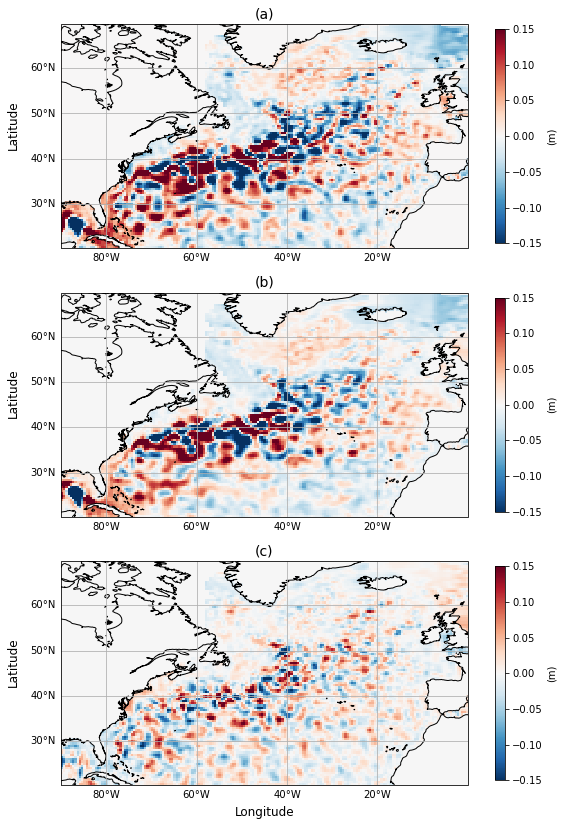

In [64]:
rebuild = np.dot(vecs[:,0:85],EOFs.T[0:85,:]) # size: (326, 326) 
# vec size: (326, 326)
# EOFs.T size: (326, 18100)

rebuild = rebuild.T + meandata.T   
rebuild = np.reshape(rebuild.T, (nt, len(lat), len(lon)), order='F')  # size: (326, 100, 181)

difference = rebuild[109,:,:] - sla[109,:,:]
#_________________________________________________________________________________________________________________________________________#

# PLOTS FOR RECONSTRUCTION 
#fig, ax = plt.subplots(3,1,figsize=(12,14))
fig= plt.figure(figsize=(12, 14))
fig.tight_layout(pad=4.0)

#Plot the Sea Surface Height Anomaly for June 2012
ax[0] = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax[0].imshow(sla[109,:,:], vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im,fraction=0.016, pad=0.04, ax=ax[0])
cbar.set_label('(m)')
ax[0].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[0].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[0].set_title(r'(a)', fontsize=14)
ax[0].add_feature(cfeature.LAND)
ax[0].coastlines(resolution='50m')
ax[0].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
ax[0].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[0].transAxes)
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#Plot the reconstructed Sea Surface Height Anomaly for June 2012
ax[1] = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
im = ax[1].imshow(rebuild[109,:,:], vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im,fraction=0.016, pad=0.04, ax=ax[1])
cbar.set_label('(m)')
ax[1].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[1].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[1].set_title(r'(b)',fontsize=14)
ax[1].coastlines(resolution='50m')
ax[1].add_feature(cfeature.LAND)
ax[1].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
ax[1].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[1].transAxes)
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#Plot the difference between reconstructed and observed for June 2012
ax[2] = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
im = ax[2].imshow(difference, vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im,fraction=0.016, pad=0.04, ax=ax[2])
cbar.set_label('(m)')
ax[2].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[2].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[2].set_title(r'(c)',fontsize=14)
ax[2].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[2].transAxes)
ax[2].text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax[2].transAxes)
ax[2].coastlines(resolution='50m')
ax[2].add_feature(cfeature.LAND)
ax[2].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
gl = ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#plt.savefig(filepath+"DifferencesJune2012.png",bbox_inches='tight')

plt.show()

### A map of the standard deviation of the reconstructed data set ( Results ) 

(100, 181)


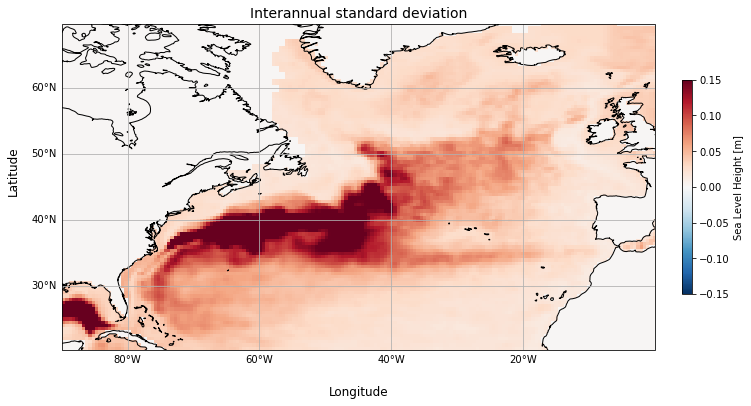

In [65]:
sigma_rec = np.std(rebuild[:,:,:], axis=0)  
print(sigma_rec.shape)            # size: (100,181)

#set up the figure
fig, ax = plt.subplots(1,1,figsize=(12,6))

# add coastlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

# plot the data
im = ax.imshow(sigma_rec, vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])

# Set colorbar, the labels of the axis and the title
plt.colorbar(im,fraction=0.016, pad=0.04, label = "Sea Level Height [m]")
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)
ax.set_title(r'Interannual standard deviation', fontsize=14)

# add gridlines with lat and lon
ax.set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

# save figure
#plt.savefig(filepath+"std_recon.png", bbox_inches='tight')
plt.show()

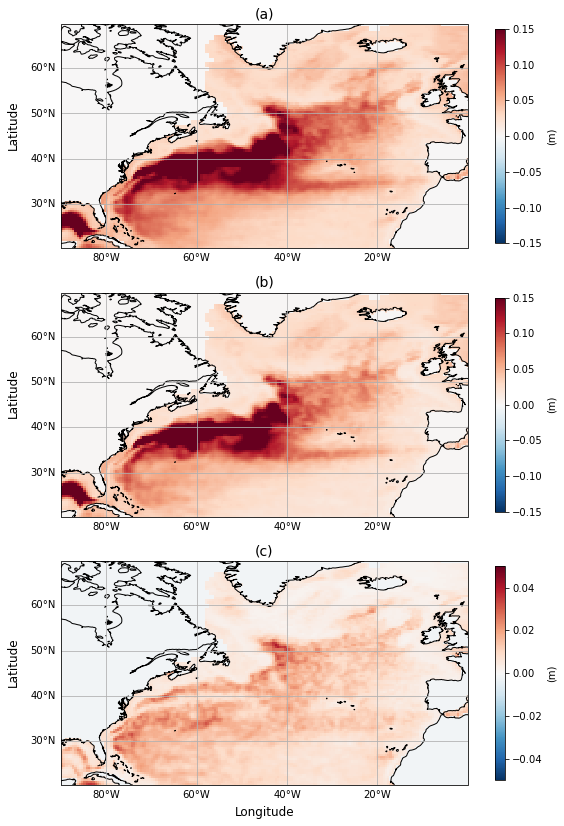

In [68]:
diff = sigma - sigma_rec

# PLOTS FOR RECONSTRUCTION 
#fig, ax = plt.subplots(3,1,figsize=(12,14))
fig= plt.figure(figsize=(12, 14))
fig.tight_layout(pad=4.0)

#Plot the Sea Surface Height Anomaly for June 2012
ax[0] = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
im1 = ax[0].imshow(sigma, vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im1,fraction=0.016, pad=0.04, ax=ax[0])
cbar.set_label('(m)')
ax[0].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[0].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[0].set_title(r'(a)', fontsize=14)
ax[0].add_feature(cfeature.LAND)
ax[0].coastlines(resolution='50m')
ax[0].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
ax[0].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[0].transAxes)
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#Plot the reconstructed Sea Surface Height Anomaly for June 2012
ax[1] = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
im2 = ax[1].imshow(sigma_rec, vmin=-0.15,vmax=+0.15, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im2,fraction=0.016, pad=0.04, ax=ax[1])
cbar.set_label('(m)')
ax[1].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[1].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[1].set_title(r'(b)',fontsize=14)
ax[1].coastlines(resolution='50m')
ax[1].add_feature(cfeature.LAND)
ax[1].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
ax[1].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[1].transAxes)
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#Plot the difference between reconstructed and observed for June 2012
ax[2] = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
im3 = ax[2].imshow(diff, vmin=-0.05,vmax=+0.05, cmap=plt.cm.RdBu_r, interpolation='none',extent=[lon[0],lon[-1],lat[0],lat[-1]])
cbar=plt.colorbar(im3,fraction=0.016, pad=0.04, ax=ax[2])
cbar.set_label('(m)')
ax[2].set_xlabel(r'Longitude ($^\circ$E)',fontsize=12)
ax[2].set_ylabel(r'Latitude ($^\circ$N)',fontsize=12)
ax[2].set_title(r'(c)',fontsize=14)
ax[2].text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax[2].transAxes)
ax[2].text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=12,
        transform=ax[2].transAxes)
ax[2].coastlines(resolution='50m')
ax[2].add_feature(cfeature.LAND)
ax[2].set_extent([-90, 0, 20.25, 69.75], crs=ccrs.PlateCarree())
gl = ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = False

#plt.savefig(filepath+"Diff_std.png",bbox_inches='tight')

plt.show()


## Correlation Analysis

Correlation analysis of the time series of the EOF coefficients with climate indices such as the North Atlantic Oscillation, Atlantic Multidecadal Oscillation, ENSO

### A. Monthly correlation

In [69]:
# Change the representation of the PCs data: decimal representaion -> Y-m
import datetime
from dateutil.relativedelta import relativedelta

date_PCs=[]
start = datetime.datetime.strptime("01-04-1993", "%d-%m-%Y")
end = datetime.datetime.strptime("01-05-2020", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*27+2)]

for date in date_generated:
    date_PCs.append(date.strftime("%Y-%m"))
date_PCs = np.array(date_PCs,dtype=str)

In [70]:
#---------------------------------------Open data - only for monthly data -----------------------------------------

#------------------------------- North Atlantic Oscillation Index (NAO)---------------------------------------------
NAO_time = np.loadtxt("NAO (monthly).txt")[:, 0]
NAO_amp = np.loadtxt("NAO (monthly).txt")[:, 1]

# Find the index of the first date (1993-04-01)
date_0 = np.where(NAO_time == np.round(time[0],2))[0][0]
# Find the index of the last date (2020-05-31)
date_end = np.where(NAO_time == np.round(time[len(time)-1],2))[0][0]

NAO_time_analysis=[]
NAO_amp_analysis=[]

for i in range(date_0,date_end+1):
    NAO_time_analysis.append(NAO_time[i])
    NAO_amp_analysis.append(NAO_amp[i])
    
#1993-2020
NAO_time_analysis = np.array(NAO_time_analysis)
NAO_amp_analysis = np.array(NAO_amp_analysis)

#--------------------------------- Greenland Blocking Index (GBI) ------------------------------------------------------
Green_time = np.loadtxt("Greenland_blocking_index (monthly).txt")[:, 0]
Green_amp = np.loadtxt("Greenland_blocking_index (monthly).txt")[:, 1]

date_0 = np.where(Green_time == np.round(time[0],2))[0][0]
date_end = np.where(Green_time == np.round(time[len(time)-1],2))[0][0]

Green_time_analysis=[]
Green_amp_analysis=[]

for i in range(date_0,date_end+1):
    Green_time_analysis.append(Green_time[i])
    Green_amp_analysis.append(Green_amp[i])

#1993-2020
Green_time_analysis = np.array(Green_time_analysis)
Green_amp_analysis = np.array(Green_amp_analysis)

#--------------------------- Atlantic Multidecadal Oscillation index (AMO)----------------------------------------------
AMO_time = np.loadtxt("AMO (monthly).txt")[:, 0]
AMO_amp = np.loadtxt("AMO (monthly).txt")[:, 1]

date_0 = np.where(AMO_time == np.round(time[0],2))[0][0]
date_end = np.where(AMO_time == np.round(time[len(time)-1],2))[0][0]

AMO_time_analysis=[]
AMO_amp_analysis=[]

for i in range(date_0,date_end+1):
    AMO_time_analysis.append(AMO_time[i])
    AMO_amp_analysis.append(AMO_amp[i])

#1993-2020
AMO_time_analysis = np.array(AMO_time_analysis)
AMO_amp_analysis = np.array(AMO_amp_analysis)

#------------------------------------------------------ ElNINO ----------------------------------------------------------
#------------------NINO1+2 (0-10S, 80-90W)
Nino12_time = np.loadtxt("NINO12 (monthly).txt")[:, 0]
Nino12_amp = np.loadtxt("NINO12 (monthly).txt")[:, 1]

date_0 = np.where(Nino12_time == np.round(time[0],2))[0][0]
date_end = np.where(Nino12_time == np.round(time[len(time)-1],2))[0][0]

Nino12_time_analysis=[]
Nino12_amp_analysis=[]

for i in range(date_0,date_end+1):
    Nino12_time_analysis.append(Nino12_time[i])
    Nino12_amp_analysis.append(Nino12_amp[i])

#1993-2020
Nino12_time_analysis = np.array(Nino12_time_analysis)
Nino12_amp_analysis = np.array(Nino12_amp_analysis)


#----------------Elnino3  (5S-5N; 150W-90W)
Nino3_time = np.loadtxt("NINO3 (monthly).txt")[:, 0]
Nino3_amp = np.loadtxt("NINO3 (monthly).txt")[:, 1]

date_0 = np.where(Nino3_time == np.round(time[0],2))[0][0]
date_end = np.where(Nino3_time == np.round(time[len(time)-1],2))[0][0]

Nino3_time_analysis=[]
Nino3_amp_analysis=[]

for i in range(date_0,date_end+1):
    Nino3_time_analysis.append(Nino3_time[i])
    Nino3_amp_analysis.append(Nino3_amp[i])

#1993-2020
Nino3_time_analysis = np.array(Nino3_time_analysis)
Nino3_amp_analysis = np.array(Nino3_amp_analysis)

#---------------NINO3.4 (5S-5N; 170W-120W) 
Nino34_time = np.loadtxt("NINO34 (monthly).txt")[:, 0]
Nino34_amp = np.loadtxt("NINO34 (monthly).txt")[:, 1]

date_0 = np.where(Nino34_time == np.round(time[0],2))[0][0]
date_end = np.where(Nino34_time == np.round(time[len(time)-1],2))[0][0]

Nino34_time_analysis=[]
Nino34_amp_analysis=[]

for i in range(date_0,date_end+1):
    Nino34_time_analysis.append(Nino34_time[i])
    Nino34_amp_analysis.append(Nino34_amp[i])

#1993-2020    
Nino34_time_analysis = np.array(Nino34_time_analysis)
Nino34_amp_analysis = np.array(Nino34_amp_analysis)


#----------------NINO4 (5S-5N: 160E-150W)
Nino4_time = np.loadtxt("NINO4 (monthly).txt")[:, 0]
Nino4_amp = np.loadtxt("NINO4 (monthly).txt")[:, 1]

date_0 = np.where(Nino4_time == np.round(time[0],2))[0][0]
date_end = np.where(Nino4_time == np.round(time[len(time)-1],2))[0][0]

Nino4_time_analysis=[]
Nino4_amp_analysis=[]

for i in range(date_0,date_end+1):
    Nino4_time_analysis.append(Nino4_time[i])
    Nino4_amp_analysis.append(Nino4_amp[i])

#1993-2020
Nino4_time_analysis = np.array(Nino4_time_analysis)
Nino4_amp_analysis = np.array(Nino4_amp_analysis)

#------------------------------------------- Arctic Oscillaiton index (AO)---------------------------------------
import xarray as xr
import netCDF4
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

data=xr.open_dataset("icpc_ao.nc", decode_times=False)
AO_amp = data.AO.values
AO_time = data.time.values

# Create a new array with dates for AO
AO_date=[]
start = datetime.datetime.strptime("01-01-1950", "%d-%m-%Y")
end = datetime.datetime.strptime("01-08-2021", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*72)]

for date in date_generated:
    AO_date.append(date.strftime("%Y-%m"))
AO_date = np.array(AO_date)

# Find the first date of the array date_PCs ('04-1993')
date_0 = np.where(AO_date == date_PCs[0])[0][0]
# Find the last date of the array date_PCs ('05-2020')
date_end = np.where(AO_date == date_PCs[len(date_PCs)-1])[0][0]

AO_time_analysis=[]
AO_amp_analysis=[]

for i in range(date_0,date_end+1):
    AO_time_analysis.append(AO_date[i])
    AO_amp_analysis.append(AO_amp[i])

#1993-2020
AO_time_analysis = np.array(AO_time_analysis)
AO_amp_analysis = np.array(AO_amp_analysis)


#------------------------------------------ Tropical Northern Atlantic Index (TNA) -----------------------------------
TNA_time = np.loadtxt("TNA (monthly).txt")[:, 0]

# Create a new array with dates for TNA
date_TNA=[]
start = datetime.datetime.strptime("01-01-1948", "%d-%m-%Y")
end = datetime.datetime.strptime("01-12-2022", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*74)]

for date in date_generated:
    date_TNA.append(date.strftime("%Y-%m"))
date_TNA = np.array(date_TNA)

# Create a new array with amplitudes of TNA 
TNA_amp_col = np.loadtxt("TNA (monthly).txt")[:, 1:13] # n * 12 columns
TNA_amp_col = TNA_amp_col.reshape([74*12,1]) # array n * 1 column
TNA_amp= []
for i in range(len(TNA_amp_col)):
    TNA_amp.append(TNA_amp_col[i][0])
TNA_amp = np.array(TNA_amp)


# Find the first date of the array date_PCs ('04-1993')
date_0 = np.where(date_TNA == date_PCs[0])[0][0]
# Find the last date of the array date_PCs ('05-2020')
date_end = np.where(date_TNA == date_PCs[len(date_PCs)-1])[0][0]

TNA_time_analysis=[]
TNA_amp_analysis=[]

for i in range(date_0,date_end+1):
    TNA_time_analysis.append(date_TNA[i])
    TNA_amp_analysis.append(TNA_amp[i])

#1993-2020    
TNA_time_analysis = np.array(TNA_time_analysis)
TNA_amp_analysis = np.array(TNA_amp_analysis)


# ----------------------------------Atlantic Meridional Mode index (AMM)------------------------------------------
AMM_time = np.loadtxt("AMM (monthly).txt")[:, 0]

# Create a new array with dates for AMM
date_AMM=[]
start = datetime.datetime.strptime("01-01-1948", "%d-%m-%Y")
end = datetime.datetime.strptime("01-12-2022", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*74)]

for date in date_generated:
    date_AMM.append(date.strftime("%Y-%m"))
date_AMM = np.array(date_AMM)

# Create a new array with amplitudes of AMM 
AMM_amp_col = np.loadtxt("AMM (monthly).txt")[:, 1:13] # n * 12 columns
AMM_amp_col = AMM_amp_col.reshape([74*12,1]) # array n * 1 column
AMM_amp= []
for i in range(len(AMM_amp_col)):
    AMM_amp.append(AMM_amp_col[i][0])
AMM_amp = np.array(AMM_amp)
AMM_amp

# Find the first date of the array date_PCs ('04-1993')
date_0 = np.where(date_AMM== date_PCs[0])[0][0]
# Find the last date of the array date_PCs ('005-2020')
date_end = np.where(date_AMM == date_PCs[len(date_PCs)-1])[0][0]

AMM_time_analysis=[]
AMM_amp_analysis=[]

for i in range(date_0,date_end+1):
    AMM_time_analysis.append(date_AMM[i])
    AMM_amp_analysis.append(AMM_amp[i])

#1993-2020    
AMM_time_analysis = np.array(AMM_time_analysis)
AMM_amp_analysis = np.array(AMM_amp_analysis)


# ----------------------------------Florida Current (FC) ------------------------------------------
data=xr.open_dataset("iFC_monthly.nc", decode_times=False)
values_F = data.Florida.values
time_F = data.time.values

# Create a new array with dates for F
date_F=[]
start = datetime.datetime.strptime("01-01-1982", "%d-%m-%Y")
end = datetime.datetime.strptime("01-12-2020", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*39)]

for date in date_generated:
    date_F.append(date.strftime("%Y-%m"))
date_F = np.array(date_F)

# Find the first date of the array date_PCs ('01-2008')
date_0 = np.where(date_F == date_PCs[177])[0][0]
# Find the last date of the array date_PCs ('12-2012')
date_end = np.where(date_F == date_PCs[236])[0][0]

F_time_analysis=[]
F_amp_analysis=[]

for i in range(date_0,date_end+1):
    F_time_analysis.append(date_F[i])
    F_amp_analysis.append(values_F[i])
    
#2008-2012
F_time_analysis = np.array(F_time_analysis)
F_amp_analysis = np.array(F_amp_analysis)

# Create a new array for PCs for the first mode only 
PCs_0812=np.zeros([60,1])
time_0812=np.zeros(60)
for i in range(60):
    PCs_0812[i,0]=PCs[i+177,0]
    time_0812[i]=time[i+177]

PCs_new= []
time_new =[]
for i in range(len(PCs_0812)):
    PCs_new.append(PCs_0812[i][0])
    time_new.append(time_0812[i])
PCs_new = np.array(PCs_new)
time_new = np.array(time_new)

In [71]:
# Change the representation of the date for the climate indices: decimal representaion -> Y-m-d H-M-S

from datetime import datetime, timedelta

NAO_date=[];Green_date=[];AMO_date=[];Nino12_date=[];Nino3_date = [];Nino34_date=[];Nino4_date=[]


for i in range(len(NAO_time)):
    start = NAO_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    NAO_date.append(str(result))
NAO_date=np.array(NAO_date)
    
for i in range(len(Green_time)):
    start = Green_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    Green_date.append(str(result))
Green_date=np.array(Green_date)
    
for i in range(len(AMO_time)):
    start = AMO_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    AMO_date.append(str(result))
AMO_date=np.array(AMO_date)

for i in range(len(Nino12_time)):
    start = Nino12_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    Nino12_date.append(str(result))
Nino12_date=np.array(Nino12_date)

for i in range(len(Nino3_time)):
    start = Nino3_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    Nino3_date.append(str(result))
Nino3_date=np.array(Nino3_date)

for i in range(len(Nino34_time)):
    start = Nino34_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    Nino34_date.append(str(result))
Nino34_date=np.array(Nino34_date)

for i in range(len(Nino4_time)):
    start = Nino4_time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond)
    Nino4_date.append(str(result))
Nino4_date=np.array(Nino4_date)


### Plot the timeseries of climate indices

Text(0.5, 0, 'time')

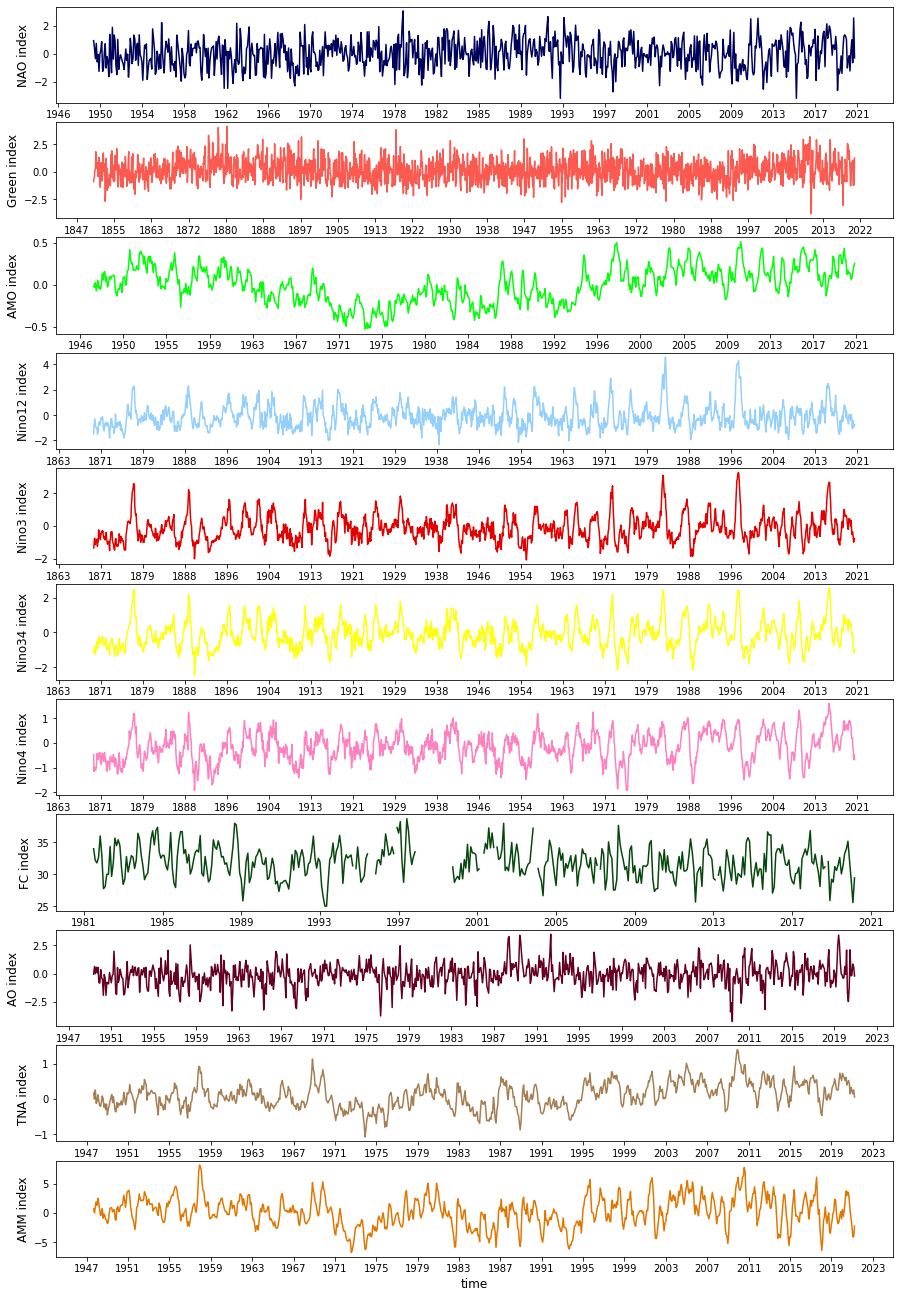

In [72]:
#------------------ Plot the timeseries of climate indices ----------------------
import matplotlib.dates as mdates
from datetime import datetime, timedelta

fig1, axs = plt.subplots(11, 1,figsize=(15,23))
x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in NAO_date]
axs[0].plot(x_values,NAO_amp,color='xkcd:dark blue',linewidth=1.5)
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=47))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[0].set_ylabel('NAO index',fontsize=12)
#axs[0].set_xlabel('time',fontsize=12)
#axs[0].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in Green_date]
axs[1].plot(x_values,Green_amp,color='xkcd:coral',linewidth=1.5)
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=100))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[1].set_ylabel('Green index',fontsize=12)
#axs[1].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in AMO_date]
axs[2].plot(x_values[:len(x_values)-4],AMO_amp[:len(AMO_amp)-4],color='xkcd:bright green',linewidth=1.5)
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=50))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[2].set_ylabel('AMO index',fontsize=12)
axs[2].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in Nino12_date]
axs[3].plot(x_values,Nino12_amp,color='xkcd:light blue',linewidth=1.5)
axs[3].xaxis.set_major_locator(mdates.MonthLocator(interval=100))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[3].set_ylabel('Nino12 index',fontsize=12)
#axs[0].set_xlabel('time',fontsize=12)
#axs[0].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in Nino3_date]
axs[4].plot(x_values, Nino3_amp,color='xkcd:red',linewidth=1.5)
axs[4].xaxis.set_major_locator(mdates.MonthLocator(interval=100))
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[4].set_ylabel('Nino3 index',fontsize=12)
#axs[1].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in Nino34_date]
axs[5].plot(x_values, Nino34_amp,color='xkcd:yellow',linewidth=1.5)
axs[5].xaxis.set_major_locator(mdates.MonthLocator(interval=100))
axs[5].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[5].set_ylabel('Nino34 index',fontsize=12)
#axs[1].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in Nino4_date]
axs[6].plot(x_values, Nino4_amp, color='xkcd:pink',linewidth=1.5)
axs[6].xaxis.set_major_locator(mdates.MonthLocator(interval=100))
axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[6].set_ylabel('Nino4 index',fontsize=12)
axs[6].set_xlabel('time',fontsize=12)
#axs[1].legend()


x_values = [datetime.strptime(d,"%Y-%m").date() for d in date_F]
axs[7].plot(x_values,values_F, color='xkcd:forest green',linewidth=1.5)
axs[7].xaxis.set_major_locator(mdates.MonthLocator(interval=48))
axs[7].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[7].set_ylabel('FC index',fontsize=12)
axs[7].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m").date() for d in AO_date]
axs[8].plot(x_values,AO_amp, color='xkcd:maroon',linewidth=1.5)
axs[8].xaxis.set_major_locator(mdates.MonthLocator(interval=48))
axs[8].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[8].set_ylabel('AO index',fontsize=12)
axs[8].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m").date() for d in date_TNA]
axs[9].plot(x_values[:len(x_values)-4],TNA_amp[:len(TNA_amp)-4], color='xkcd:puce',linewidth=1.5)
axs[9].xaxis.set_major_locator(mdates.MonthLocator(interval=48))
axs[9].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[9].set_ylabel('TNA index',fontsize=12)
axs[9].set_xlabel('time',fontsize=12)
#axs[1].legend()

x_values = [datetime.strptime(d,"%Y-%m").date() for d in date_AMM]
axs[10].plot(x_values[:len(x_values)-4],AMM_amp[:len(AMM_amp)-4], color='xkcd:pumpkin',linewidth=1.5)
axs[10].xaxis.set_major_locator(mdates.MonthLocator(interval=48))
axs[10].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#axs[0].autofmt_xdate() # Rotation
axs[10].set_ylabel('AMM index',fontsize=12)
axs[10].set_xlabel('time',fontsize=12)
#axs[1].legend()

#plt.savefig(filepath+'climate_index_timeseries.png',format='png')

In [73]:
# Reshape the arrays
NAO_amp_analysis = NAO_amp_analysis.reshape(1,-1)[0]
Green_amp_analysis = Green_amp_analysis.reshape(1,-1)[0]
AMO_amp_analysis = AMO_amp_analysis.reshape(1,-1)[0]
Nino12_amp_analysis = Nino12_amp_analysis.reshape(1,-1)[0]
Nino3_amp_analysis =Nino3_amp_analysis.reshape(1,-1)[0]
Nino34_amp_analysis = Nino34_amp_analysis.reshape(1,-1)[0]
Nino4_amp_analysis = Nino4_amp_analysis.reshape(1,-1)[0]
AO_amp_analysis = AO_amp_analysis.reshape(1,-1)[0]

# Find the correlation
rNAO = np.corrcoef(PCs[:,0],NAO_amp_analysis[:])[1,0]
rGreen = np.corrcoef(PCs[:,0],Green_amp_analysis[:])[1,0]
rAMO = np.corrcoef(PCs[:,0],AMO_amp_analysis[:])[1,0]
rNino12 = np.corrcoef(PCs[:,0],Nino12_amp_analysis[:])[1,0]
rNino3 = np.corrcoef(PCs[:,0],Nino3_amp_analysis[:])[1,0]
rNino34 = np.corrcoef(PCs[:,0],Nino34_amp_analysis[:])[1,0]
rNino4 = np.corrcoef(PCs[:,0],Nino4_amp_analysis[:])[1,0]
rAO = np.corrcoef(PCs[:,0],AO_amp_analysis[:])[1,0]
rTNA = np.corrcoef(PCs[:,0],TNA_amp_analysis[:])[1,0]
rAMM = np.corrcoef(PCs[:,0],AMM_amp_analysis[:])[1,0]
rF= np.corrcoef(PCs_new[:],F_amp_analysis[:])[1,0]

# Results only
print('monthly')
print('EOF coef - NAO index:  r = ' + str(np.round(rNAO,2)))
print('EOF coef - GBI index:  r = ' + str(np.round(rGreen,2)))
print('EOF coef - AMO index:  r = ' + str(np.round(rAMO,2)))
print('EOF coef - Nino12 index:  r = ' + str(np.round(rNino12,2)))
print('EOF coef - Nino3 index:  r = ' + str(np.round(rNino3,2)))
print('EOF coef - Nino34 index:  r = ' + str(np.round(rNino34,2)))
print('EOF coef - Nino4 index:  r = ' + str(np.round(rNino4,2)))
print('EOF coef - AO index:  r = ' + str(np.round(rAO,2)))
print('EOF coef - TNA index:  r = ' + str(np.round(rTNA,2)))
print('EOF coef - AMM index:  r = ' + str(np.round(rAMM,2)))
print('EOF coef - FC index:  r = ' + str(np.round(rF,2)))

monthly
EOF coef - NAO index:  r = 0.24
EOF coef - GBI index:  r = -0.19
EOF coef - AMO index:  r = -0.28
EOF coef - Nino12 index:  r = 0.12
EOF coef - Nino3 index:  r = 0.18
EOF coef - Nino34 index:  r = 0.25
EOF coef - Nino4 index:  r = 0.32
EOF coef - AO index:  r = 0.19
EOF coef - TNA index:  r = -0.52
EOF coef - AMM index:  r = -0.53
EOF coef - FC index:  r = 0.17


## B. In summer

### Summer data for PCs (1993-2020)

In [74]:
# Change the representation of the date of the sla data: decimal representaion -> Y-m-d H-M-S
from datetime import datetime, timedelta
date=[]

#1993-2020
for i in range(len(time)):
    start = time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    date.append(str(result))
date=np.array(date)

# Fill an array with the indices of summer months
summer_date = []

for i in range(len(date)):
    start = datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(date == date[i])[0][0] # save the index of this date
        summer_date.append(index)
summer_date  = np.array(summer_date) 

# Find the PCs only for the summer months
summer_PCs=[]
for i in range(len(summer_date)):
    summer_PCs.append(PCs[summer_date[i],:])
summer_PCs = np.array(summer_PCs)
#print(summer_PCs.shape)  # 4 months * 27 years = 108  -> (108,326)

# Take the mean values of summer months (4months) - > we want only one value for each year
k = int(len(summer_PCs)/4) 
summer_PCs_mean = np.zeros([k,len(summer_PCs[0,:])])

for i in range(0,k):
    for j in range(326):
        result = (summer_PCs[4*i:4*(i+1),j]) # take the mean every 4 values
        ha = result.mean(axis=0)
        summer_PCs_mean[i,j] = ha
        
#summer_PCs_mean.shape -> (27,326)

### Summer data for climate indices 

In [75]:
# Create an array for years 
date_manual = np.arange(1993,2020,1)
date_manual = np.array(date_manual,dtype=float)
date_manual

# -----------------------------------------------Open data ---------------------------------------------------------

#---------------------------------------------------- NOA index-------------------------------------------------------
NAO_time = np.loadtxt("NAO_summer (Jun-Jul-Aug-Sep).txt")[:, 0]
NAO_amp = np.loadtxt("NAO_summer (Jun-Jul-Aug-Sep).txt")[:, 1]

NAO_time_analysis=[]
NAO_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(NAO_time == date_manual[i])[0][0]
    NAO_time_analysis.append(NAO_time[date_0])
    NAO_amp_analysis.append(NAO_amp[date_0])
    
#1993-2020
NAO_time_analysis = np.array(NAO_time_analysis)
NAO_amp_analysis = np.array(NAO_amp_analysis)


# -----------------------------------------------GBI index ---------------------------------------------------------------
Green_time = np.loadtxt("Greenland_blocking_index_summer (Jun-Jul-Aug-Sep).txt")[:, 0]
Green_amp = np.loadtxt("Greenland_blocking_index_summer (Jun-Jul-Aug-Sep).txt")[:, 1]


Green_time_analysis=[]
Green_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Green_time == date_manual[i])[0][0]
    Green_time_analysis.append(Green_time[date_0])
    Green_amp_analysis.append(Green_amp[date_0])

#1993-2020
Green_time_analysis = np.array(Green_time_analysis)
Green_amp_analysis = np.array(Green_amp_analysis)


#------------------------------------------------- AMO index --------------------------------------------------------------
AMO_time = np.loadtxt("AMO_summer (Jun-Jul-Aug-Sep).txt")[:, 0]
AMO_amp = np.loadtxt("AMO_summer (Jun-Jul-Aug-Sep).txt")[:, 1]

AMO_time_analysis=[]
AMO_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(AMO_time == date_manual[i])[0][0]
    AMO_time_analysis.append(AMO_time[date_0])
    AMO_amp_analysis.append(AMO_amp[date_0])

#1993-2020
AMO_time_analysis = np.array(AMO_time_analysis)
AMO_amp_analysis = np.array(AMO_amp_analysis)


# --------------------------------------------------AO index----------------------------------------------------------
# Fill an array with the indices of summer months
summer_date_AO = []

for i in range(len(AO_time_analysis)):
    start = datetime.strptime(AO_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(AO_time_analysis == AO_time_analysis[i])[0][0] # save the index of this date
        summer_date_AO.append(index)
summer_date_AO  = np.array(summer_date_AO) 

# Find the AO index only for the summer months
summer_AO=[]
for i in range(len(summer_date_AO)):
    summer_AO.append(AO_amp_analysis[summer_date_AO[i]])
summer_AO = np.array(summer_AO)

# Take the mean values of summer months (4months) - > we want only one value for each year
k = int(len(summer_AO)/4) 
summer_AO_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(summer_AO[4*i:4*(i+1)]) # take the mean every 4 values
    summer_AO_mean[i] = result
    

    
# --------------------------------------------------TNA index------------------------------------------------------
# Fill an array with the indices of summer months
summer_date_TNA = []

for i in range(len(TNA_time_analysis)):
    start = datetime.strptime(TNA_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(TNA_time_analysis == TNA_time_analysis[i])[0][0] # save the index of this date
        summer_date_TNA.append(index)
summer_date_TNA  = np.array(summer_date_TNA) 

# Find the TNA index only for the summer months
summer_TNA=[]
for i in range(len(summer_date_TNA)):
    summer_TNA.append(TNA_amp_analysis[summer_date_TNA[i]])
summer_TNA = np.array(summer_TNA)


# Take the mean values of summer months (4months) - > we want only one value for each year
k = int(len(summer_TNA)/4) 
summer_TNA_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(summer_TNA[4*i:4*(i+1)]) # take the mean every 4 values
    summer_TNA_mean[i] = result

    
# ----------------------------------------------AMM index----------------------------------------------------
# Fill an array with the indices of summer months
summer_date_AMM = []

for i in range(len(AMM_time_analysis)):
    start = datetime.strptime(AMM_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(AMM_time_analysis == AMM_time_analysis[i])[0][0] # save the index of this date
        summer_date_AMM.append(index)
summer_date_AMM  = np.array(summer_date_AMM) 

# Find the AMM index only for the summer months
summer_AMM=[]
for i in range(len(summer_date_AMM)):
    summer_AMM.append(AMM_amp_analysis[summer_date_AMM[i]])
summer_AMM = np.array(summer_AMM)


# Take the mean values of summer months (4months) - > we want only one value for each year
k = int(len(summer_AMM)/4) 
summer_AMM_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(summer_AMM[4*i:4*(i+1)]) # take the mean every 4 values
    summer_AMM_mean[i] = result
    

    
# ----------------------------------------------FC index----------------------------------------------------  


# Define a new array for date for period 2008-2012
# Find the PCs between 2008-2012
from datetime import datetime, timedelta
date=[]

for i in range(len(time_new)):
    start = time_new[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    date.append(str(result))
date=np.array(date)

# Fill an array with the indices of summer months
summer_dateF = []

for i in range(len(date)):
    start = datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(date == date[i])[0][0] # save the index of this date
        summer_dateF.append(index)
summer_dateF  = np.array(summer_dateF) 

# Find the PCs only for the summer months
summer_PCsF=[]
for i in range(len(summer_dateF)):
    summer_PCsF.append(PCs_new[summer_dateF[i]])
summer_PCsF = np.array(summer_PCsF)


# Take the mean values of summer months (4months) - > we want only one value for each year
k = int(len(summer_PCsF)/4) # 5 values
summer_PCs_meanF = np.zeros(k)

for i in range(0,k):
    result = np.mean(summer_PCsF[4*i:4*(i+1)]) # take the mean every 4 values
    summer_PCs_meanF[i] = result 
    

# Find the FC index between 2008-2012

from datetime import datetime, timedelta

# Fill an array with the indices of summer months
summer_date = []

for i in range(len(F_time_analysis)):
    start = datetime.strptime(F_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '06' or start == '07' or start == '08' or start == '09':
        index = np.where(F_time_analysis == F_time_analysis[i])[0][0] # save the index of this date
        summer_date.append(index)
summer_date  = np.array(summer_date) 

# Find the FC only for the summer months
summer_F=[]
for i in range(len(summer_date)):
    summer_F.append(F_amp_analysis[summer_date[i]])
summer_F = np.array(summer_F,dtype=float)

# Take the mean values of summer months (4months) - > we want only one value for each year
k= int(len(summer_F)/4) # 5 values
summer_F_mean = np.zeros(k)
for i in range(0,k):
    result = np.mean(summer_F[4*i:4*(i+1)]) # take the mean every 4 values
    summer_F_mean[i] = result


In [76]:
# Reshape the arrays
NAO_amp_analysis = NAO_amp_analysis.reshape(1,-1)[0]
Green_amp_analysis = Green_amp_analysis.reshape(1,-1)[0]
AMO_amp_analysis = AMO_amp_analysis.reshape(1,-1)[0]

# Find the correlation
rNAO = np.corrcoef(summer_PCs_mean[:,0],NAO_amp_analysis[:])[1,0]
rGreen = np.corrcoef(summer_PCs_mean[:,0],Green_amp_analysis[:])[1,0]
rAMO = np.corrcoef(summer_PCs_mean[:,0],AMO_amp_analysis[:])[1,0]
rAO = np.corrcoef(summer_PCs_mean[:,0],summer_AO_mean[:])[1,0]
rTNA = np.corrcoef(summer_PCs_mean[:,0],summer_TNA_mean[:])[1,0]
rAMM = np.corrcoef(summer_PCs_mean[:,0],summer_AMM_mean[:])[1,0]
rF = np.corrcoef(summer_PCs_meanF[:],summer_F_mean[:])[1,0]

# Results only
print('summer')
print('EOF coef - NAO index:  r = ' + str(np.round(rNAO,4)))
print('EOF coef - GBI index:  r = ' + str(np.round(rGreen,4)))
print('EOF coef - AMO index:  r = ' + str(np.round(rAMO,4)))
print('EOF coef - AO index:  r = ' + str(np.round(rAO,4)))
print('EOF coef - TNA index:  r = ' + str(np.round(rTNA,4)))
print('EOF coef - AMM index:  r = ' + str(np.round(rAMM,4)))
print('EOF coef - FC index:  r = ' + str(np.round(rF,4)))


summer
EOF coef - NAO index:  r = 0.1133
EOF coef - GBI index:  r = -0.1536
EOF coef - AMO index:  r = -0.3475
EOF coef - AO index:  r = 0.2599
EOF coef - TNA index:  r = -0.5499
EOF coef - AMM index:  r = -0.5304
EOF coef - FC index:  r = 0.2175


## C. In winter

### Winter data for PCs (1993-2020)

In [77]:
# Change the representation of the date: decimal representaion -> Y-m-d H-M-S

from datetime import datetime, timedelta
date=[]

# 1993-2020
for i in range(len(time)):
    start = time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    date.append(str(result))
date=np.array(date)

# Fill an array with the indices of winter months
winter_date = []

for i in range(len(date)): 
    start = datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S").strftime('%m')
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(date == date[i])[0][0]
        winter_date.append(index)
winter_date  = np.array(winter_date) # this corresponds to 1994-2020

# Find the PCs only for the winter months
winter_PCs=[]
for i in range(len(winter_date)):
    winter_PCs.append(PCs[winter_date[i],:])
winter_PCs = np.array(winter_PCs) # -> (108,326)


# Take the mean values of winter months (4months)
k = int(len(winter_PCs)/4)
winter_PCs_mean = np.zeros([k,len(winter_PCs[0,:])])

for i in range(0,k):
    for j in range(326):
        result = (winter_PCs[4*i:4*(i+1),j]) # take the mean every 4 values
        ha = result.mean(axis=0)
        winter_PCs_mean[i,j] = ha  # -> (27,326)


### Winter data for climate indices 

In [78]:
# Create an array for years 
date_manual = np.arange(1994,2021,1)
date_manual = np.array(date_manual,dtype=float)
date_manual

#----------------------------------------------- (NOA) index ------------------------------------------------------
NAO_time = np.loadtxt("NAO_winter (Dec-Jan-Feb-Mar).txt")[:, 0]
NAO_amp = np.loadtxt("NAO_winter (Dec-Jan-Feb-Mar).txt")[:, 1]

NAO_time_analysis=[]
NAO_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(NAO_time == date_manual[i])[0][0]
    NAO_time_analysis.append(NAO_time[date_0])
    NAO_amp_analysis.append(NAO_amp[date_0])

# 1994-2020
NAO_time_analysis = np.array(NAO_time_analysis)
NAO_amp_analysis = np.array(NAO_amp_analysis)


# -------------------------------------------------(GBI) index---------------------------------------------------------
Green_time = np.loadtxt("Greenland_blocking_index_winter (Dec-Jan-Feb-Mar).txt")[:, 0]
Green_amp = np.loadtxt("Greenland_blocking_index_winter (Dec-Jan-Feb-Mar).txt")[:, 1]


Green_time_analysis=[]
Green_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Green_time == date_manual[i])[0][0]
    Green_time_analysis.append(Green_time[date_0])
    Green_amp_analysis.append(Green_amp[date_0])
    
# 1994-2020
Green_time_analysis = np.array(Green_time_analysis)
Green_amp_analysis = np.array(Green_amp_analysis)


#--------------------------------------------------- (AMO) index-------------------------------------------------
AMO_time = np.loadtxt("AMO_winter (Dec-Jan-Feb-Mar).txt")[:, 0]
AMO_amp = np.loadtxt("AMO_winter (Dec-Jan-Feb-Mar).txt")[:, 1]

AMO_time_analysis=[]
AMO_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(AMO_time == date_manual[i])[0][0]
    AMO_time_analysis.append(AMO_time[date_0])
    AMO_amp_analysis.append(AMO_amp[date_0])

# 1994-2020    
AMO_time_analysis = np.array(AMO_time_analysis)
AMO_amp_analysis = np.array(AMO_amp_analysis)

#------------------------------------------------------ AO index-----------------------------------------------------
# Fill an array with the indices of winter months
winter_date_AO = []
for i in range(len(AO_time_analysis)):
    start = datetime.strptime(AO_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(AO_time_analysis == AO_time_analysis[i])[0][0] # save the index of this date
        winter_date_AO.append(index)
winter_date_AO  = np.array(winter_date_AO) 

# Find the PCs only for the winter months
winter_AO=[]
for i in range(len(winter_date_AO)):
    winter_AO.append(AO_amp_analysis[winter_date_AO[i]])
winter_AO = np.array(winter_AO)


# Take the mean values of winter months (4months) - > we want only one value for each year
k = int(len(winter_AO)/4) 
winter_AO_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(winter_AO[4*i:4*(i+1)]) # take the mean every 4 values
    winter_AO_mean[i] = result
    
# -----------------------------------------------------TNA index----------------------------------------------
# Fill an array with the indices of winter months
winter_date_TNA = []

for i in range(len(TNA_time_analysis)):
    start = datetime.strptime(TNA_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(TNA_time_analysis == TNA_time_analysis[i])[0][0] # save the index of this date
        winter_date_TNA.append(index)
winter_date_TNA  = np.array(winter_date_TNA) 

# Find the PCs only for the winter months
winter_TNA=[]
for i in range(len(winter_date_TNA)):
    winter_TNA.append(TNA_amp_analysis[winter_date_TNA[i]])
winter_TNA = np.array(winter_TNA)


# Take the mean values of winter months (4months) - > we want only one value for each year
k = int(len(winter_TNA)/4) 
winter_TNA_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(winter_TNA[4*i:4*(i+1)]) # take the mean every 4 values
    winter_TNA_mean[i] = result


# ----------------------------------------------AMM index----------------------------------------------------------
# Fill an array with the indices of winter months
winter_date_AMM = []

for i in range(len(AMM_time_analysis)):
    start = datetime.strptime(AMM_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(AMM_time_analysis == AMM_time_analysis[i])[0][0] # save the index of this date
        winter_date_AMM.append(index)
winter_date_AMM  = np.array(winter_date_AMM) 

# Find the PCs only for the winter months
winter_AMM=[]
for i in range(len(winter_date_AMM)):
    winter_AMM.append(AMM_amp_analysis[winter_date_AMM[i]])
winter_AMM = np.array(winter_AMM)


# Take the mean values of winter months (4months) - > we want only one value for each year
k = int(len(winter_AMM)/4) 
winter_AMM_mean = np.zeros(k)

for i in range(0,k):
    result = np.mean(winter_AMM[4*i:4*(i+1)]) # take the mean every 4 values
    winter_AMM_mean[i] = result

    
    
    
    
# ----------------------------------------------FC index---------------------------------------------------
# Define a new array with PCs for period 2009-2013

# Find the first date of the array date_PCs ('01-2008')
date_0 = np.where(date_F == date_PCs[177])[0][0]
# Find the last date of the array date_PCs ('12-2013')
date_end = np.where(date_F == date_PCs[248])[0][0]

F_time_analysis=[]
F_amp_analysis=[]

for i in range(date_0,date_end+1):
    F_time_analysis.append(date_F[i])
    F_amp_analysis.append(values_F[i])
    
F_time_analysis = np.array(F_time_analysis)
F_amp_analysis = np.array(F_amp_analysis)

# Create a new array for PCs for the first mode only 
PCs_0813=np.zeros([72,1])
time_0813=np.zeros(72)
for i in range(72):
    PCs_0813[i,0]=PCs[i+177,0]
    time_0813[i]=time[i+177]

PCs_new= []
time_new =[]
for i in range(len(PCs_0813)):
    PCs_new.append(PCs_0813[i][0])
    time_new.append(time_0813[i])
PCs_new = np.array(PCs_new)
time_new = np.array(time_new)


from datetime import datetime, timedelta
date=[]

for i in range(len(time_new)):
    start = time_new[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    date.append(str(result))
date=np.array(date)

# Fill an array with the indices of winter months
winter_dateF = []

for i in range(len(date)):
    start = datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S").strftime('%m') # here we find the month of each date
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(date == date[i])[0][0] # save the index of this date
        winter_dateF.append(index)
winter_dateF  = np.array(winter_dateF) 

# Find the PCs only for the winter months
winter_PCsF=[]
for i in range(len(winter_dateF)):
    winter_PCsF.append(PCs_new[winter_dateF[i]])
winter_PCsF = np.array(winter_PCsF)


# Take the mean values of winter months (4months) - > we want only one value for each year
k = 5 # total number of years
winter_PCs_meanF = np.zeros(k)

for i in range(0,k):
    result = np.mean(winter_PCsF[3+4*i:4*(i+1)+3]) # take the mean every 4 values
    winter_PCs_meanF[i] = result 
#print(winter_PCs_meanF) -> (5,1)

    
# Find the FC index for period 2008-2013
from datetime import datetime, timedelta

# Fill an array with the indices of winter months
winter_date = []

for i in range(len(F_time_analysis)):
    start = datetime.strptime(F_time_analysis[i], "%Y-%m").strftime('%m') # here we find the month of each date
    if start == '12' or start == '01' or start == '02' or start == '03':
        index = np.where(F_time_analysis == F_time_analysis[i])[0][0] # save the index of this date
        winter_date.append(index)
winter_date  = np.array(winter_date) 

# Find the F only for the summer months
winter_F=[]
for i in range(len(winter_date)):
    winter_F.append(F_amp_analysis[winter_date[i]])
winter_F = np.array(winter_F,dtype=float)
#print(winter_F.shape)

# Take the mean values of winter months (4months) - > we want only one value for each year
k= 5 
winter_F_mean = np.zeros(k)
for i in range(0,k):
    result = np.mean(winter_F[3+4*i:4*(i+1)+3]) # take the mean every 4 values
    winter_F_mean[i] = result
#print( winter_F_mean) -> (5,1)

In [79]:
# Reshape the arrays
NAO_amp_analysis = NAO_amp_analysis.reshape(1,-1)[0]
Green_amp_analysis = Green_amp_analysis.reshape(1,-1)[0]
AMO_amp_analysis = AMO_amp_analysis.reshape(1,-1)[0]

# Find the correlation
rNAO = np.corrcoef(winter_PCs_mean[:,0],NAO_amp_analysis[:])[1,0]
rGreen = np.corrcoef(winter_PCs_mean[:,0],Green_amp_analysis[:])[1,0]
rAMO = np.corrcoef(winter_PCs_mean[:,0],AMO_amp_analysis[:])[1,0]
rAO = np.corrcoef(winter_PCs_mean[:,0],winter_AO_mean[:])[1,0]
rTNA = np.corrcoef(winter_PCs_mean[:,0],winter_TNA_mean[:])[1,0]
rAMM = np.corrcoef(winter_PCs_mean[:,0],winter_AMM_mean[:])[1,0]
rF = np.corrcoef(winter_PCs_meanF[:],winter_F_mean[:])[1,0]


# Results only
print('winter')
print('EOF coef - NAO index:  r = ' + str(np.round(rNAO,2)))
print('EOF coef - GBI index:  r = ' + str(np.round(rGreen,2)))
print('EOF coef - AMO index:  r = ' + str(np.round(rAMO,2)))
print('EOF coef - AO index:  r = ' + str(np.round(rAO,2)))
print('EOF coef - TNA index:  r = ' + str(np.round(rTNA,2)))
print('EOF coef - AMM index:  r = ' + str(np.round(rAMM,2)))
print('EOF coef - FC index:  r = ' + str(np.round(rF,2)))

winter
EOF coef - NAO index:  r = 0.71
EOF coef - GBI index:  r = -0.63
EOF coef - AMO index:  r = -0.27
EOF coef - AO index:  r = 0.5
EOF coef - TNA index:  r = -0.6
EOF coef - AMM index:  r = -0.73
EOF coef - FC index:  r = 0.49


### El Nino July-Dec

### Jul-Dec data for PCs

In [80]:
# Change the representation of the date: decimal representaion -> Y-m-d H-M-S

#1993-2020
from datetime import datetime, timedelta
date=[]

for i in range(len(time)):
    start = time[i]
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result= result - timedelta(microseconds=result.microsecond) # round datetime object to nearest second
    date.append(str(result))

date=np.array(date)

# Fill an array with the indices of Jul-Dec months
months_date = []

for i in range(len(date)):
    start = datetime.strptime(date[i], "%Y-%m-%d %H:%M:%S").strftime('%m')
    if start == '07' or start == '08' or start == '09' or start == '10' or start == '11' or start == '12':
        index = np.where(date == date[i])[0][0]
        months_date.append(index)
        
months_date  = np.array(months_date) 

# Find the PCs only for the Jul-Dec months (6 months)
months_PCs=[]
for i in range(len(months_date)):
    months_PCs.append(PCs[months_date[i],:])
months_PCs = np.array(months_PCs)
#print(months_PCs.shape)
#print(date[months_date])

# Take the mean values of the Jul-Dec months (6 months)
k = int(len(months_PCs)/6)
months_PCs_mean = np.zeros([k,len(months_PCs[0,:])])

for i in range(0,k):
    for j in range(326):
        result = (months_PCs[6*i:6*(i+1),j]) # take the mean every 6 values
        #print(result)
        ha = result.mean(axis=0)
        months_PCs_mean[i,j] = ha
        
#months_PCs_mean.shape

### Jul-Dec data for climate indices 

In [81]:
# Create an array for years 
date_manual = np.arange(1993,2020,1)
date_manual = np.array(date_manual,dtype=float)
date_manual

# --------------- Open the data ---------------------------

#----------------------------------------------------- Nino12---------------------------------------------
Nino12_time = np.loadtxt("NINO12_JJAGSOND (July-Dec).txt")[:, 0]
Nino12_amp = np.loadtxt("NINO12_JJAGSOND (July-Dec).txt")[:, 1]

Nino12_time_analysis=[]
Nino12_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Nino12_time == date_manual[i])[0][0]
    Nino12_time_analysis.append(Nino12_time[date_0])
    Nino12_amp_analysis.append(Nino12_amp[date_0])
    
Nino12_time_analysis = np.array(Nino12_time_analysis)
Nino12_amp_analysis = np.array(Nino12_amp_analysis)


# ----------------------------------------------------Nino3--------------------------------------------------
Nino3_time = np.loadtxt("NINO3_JJAGSOND (July-Dec).txt")[:, 0]
Nino3_amp = np.loadtxt("NINO3_JJAGSOND (July-Dec).txt")[:, 1]

Nino3_time_analysis=[]
Nino3_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Nino3_time == date_manual[i])[0][0]
    Nino3_time_analysis.append(Nino3_time[date_0])
    Nino3_amp_analysis.append(Nino3_amp[date_0])
    
Nino3_time_analysis = np.array(Nino3_time_analysis)
Nino3_amp_analysis = np.array(Nino3_amp_analysis)


# -------------------------------------------------Nino34----------------------------------------------
Nino34_time = np.loadtxt("NINO34_JJAGSOND (July-Dec).txt")[:, 0]
Nino34_amp = np.loadtxt("NINO34_JJAGSOND (July-Dec).txt")[:, 1]

Nino34_time_analysis=[]
Nino34_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Nino34_time == date_manual[i])[0][0]
    Nino34_time_analysis.append(Nino34_time[date_0])
    Nino34_amp_analysis.append(Nino34_amp[date_0])
    
Nino34_time_analysis = np.array(Nino34_time_analysis)
Nino34_amp_analysis = np.array(Nino34_amp_analysis)

# --------------------------------------------------Nino4--------------------------------------------------
Nino4_time = np.loadtxt("NINO4_JJAGSOND (July-Dec).txt")[:, 0]
Nino4_amp = np.loadtxt("NINO4_JJAGSOND (July-Dec).txt")[:, 1]

Nino4_time_analysis=[]
Nino4_amp_analysis=[]

for i in range(len(date_manual)):
    date_0 = np.where(Nino4_time == date_manual[i])[0][0]
    Nino4_time_analysis.append(Nino4_time[date_0])
    Nino4_amp_analysis.append(Nino4_amp[date_0])
    
Nino4_time_analysis = np.array(Nino4_time_analysis)
Nino4_amp_analysis = np.array(Nino4_amp_analysis)

In [82]:
# Reshape the arrays
Nino12_amp_analysis = Nino12_amp_analysis.reshape(1,-1)[0]
Nino3_amp_analysis = Nino3_amp_analysis.reshape(1,-1)[0]
Nino34_amp_analysis = Nino34_amp_analysis.reshape(1,-1)[0]
Nino4_amp_analysis = Nino4_amp_analysis.reshape(1,-1)[0]

# Find the correlation
rNino12 = np.corrcoef(months_PCs_mean[:,0],Nino12_amp_analysis[:])[1,0]
rNino3 = np.corrcoef(months_PCs_mean[:,0],Nino3_amp_analysis[:])[1,0]
rNino34 = np.corrcoef(months_PCs_mean[:,0],Nino34_amp_analysis[:])[1,0]
rNino4 = np.corrcoef(months_PCs_mean[:,0],Nino4_amp_analysis[:])[1,0]

# Results only
print('Jul-Dec')
print('EOF coef - Nino12 index:  r = ' + str(np.round(rNino12,2)))
print('EOF coef - Nino3 index:  r = ' + str(np.round(rNino3,2)))
print('EOF coef - Nino34 index:  r = ' + str(np.round(rNino34,2)))
print('EOF coef - Nino4 index:  r = ' + str(np.round(rNino4,2)))

Jul-Dec
EOF coef - Nino12 index:  r = 0.17
EOF coef - Nino3 index:  r = 0.21
EOF coef - Nino34 index:  r = 0.28
EOF coef - Nino4 index:  r = 0.38


### D. Annully data

In [83]:
# Create a new array with dates 1994-2019
date_indices=[]
start = datetime.strptime("01-01-1994", "%d-%m-%Y") # we choose 1994-2019 because the data is full
end = datetime.strptime("01-12-2019", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*26)]

for date in date_generated:
    date_indices.append(date.strftime("%Y-%m"))
date_indices = np.array(date_indices)


# Find the mean value for each year only for the first EOF coefficient
PCs_mean = np.zeros([26,326])
k = 26 # number of years 1994-2019
for i in range(0,k):
    for j in range(326):
        result = (PCs[9+12*i:9+12*(i+1),j]) # take the mean every 4 values
        ha = result.mean(axis=0)
        PCs_mean[i,j] = ha
        
#PCs_mean.shape -> (26,326)


In [84]:
from datetime import datetime, timedelta
# -------------------------------------------------NAO index -------------------------------------------
NAO_time = np.loadtxt("NAO (monthly).txt")[:, 0]
NAO_amp = np.loadtxt("NAO (monthly).txt")[:, 1]

NAO_date_new=[]
for i in range(len(NAO_date)):
    start = datetime.strptime(NAO_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    NAO_date_new.append(start)
NAO_date_new = np.array(NAO_date_new)

NAO_time_analysis=[]
NAO_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(NAO_date_new == date_indices[i])[0][0]
    NAO_time_analysis.append(NAO_time[date_0])
    NAO_amp_analysis.append(NAO_amp[date_0])
    
# 1994-2019
NAO_time_analysis = np.array(NAO_time_analysis)
NAO_amp_analysis = np.array(NAO_amp_analysis)

NAO_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(NAO_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    NAO_mean[i] = result

    
# -------------------------------------------------GBI index -------------------------------------------
Green_time = np.loadtxt("Greenland_blocking_index (monthly).txt")[:, 0]
Green_amp = np.loadtxt("Greenland_blocking_index (monthly).txt")[:, 1]

Green_date_new=[]
for i in range(len(Green_date)):
    start = datetime.strptime(Green_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    Green_date_new.append(start)
Green_date_new = np.array(Green_date_new)

Green_time_analysis=[]
Green_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(Green_date_new == date_indices[i])[0][0]
    Green_time_analysis.append(Green_time[date_0])
    Green_amp_analysis.append(Green_amp[date_0])

# 1994-2019    
Green_time_analysis = np.array(Green_time_analysis)
Green_amp_analysis = np.array(Green_amp_analysis)


Green_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(Green_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    Green_mean[i] = result  
    
# -------------------------------------------------AMO index -------------------------------------------
AMO_time = np.loadtxt("AMO (monthly).txt")[:, 0]
AMO_amp = np.loadtxt("AMO (monthly).txt")[:, 1]


AMO_date_new=[]
for i in range(len(AMO_date)):
    start = datetime.strptime(AMO_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    AMO_date_new.append(start)
AMO_date_new = np.array(AMO_date_new)

AMO_time_analysis=[]
AMO_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(AMO_date_new == date_indices[i])[0][0]
    AMO_time_analysis.append(AMO_time[date_0])
    AMO_amp_analysis.append(AMO_amp[date_0])

# 1994-2019
AMO_time_analysis = np.array(AMO_time_analysis)
AMO_amp_analysis = np.array(AMO_amp_analysis)


AMO_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(AMO_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    AMO_mean[i] = result 

    
# -------------------------------------------------NINO12 index -------------------------------------------
Nino12_time = np.loadtxt("NINO12 (monthly).txt")[:, 0]
Nino12_amp = np.loadtxt("NINO12 (monthly).txt")[:, 1]

NINO12_date_new=[]
for i in range(len(Nino12_date)):
    start = datetime.strptime(Nino12_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    NINO12_date_new.append(start)
NINO12_date_new = np.array(NINO12_date_new)

NINO12_time_analysis=[]
NINO12_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(NINO12_date_new == date_indices[i])[0][0]
    NINO12_time_analysis.append(Nino12_time[date_0])
    NINO12_amp_analysis.append(Nino12_amp[date_0])

# 1994-2019
NINO12_time_analysis = np.array(NINO12_time_analysis)
NINO12_amp_analysis = np.array(NINO12_amp_analysis)


NINO12_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(NINO12_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    NINO12_mean[i] = result 
    
    
# -------------------------------------------------NINO3 index -------------------------------------------
Nino3_time = np.loadtxt("NINO3 (monthly).txt")[:, 0]
Nino3_amp = np.loadtxt("NINO3 (monthly).txt")[:, 1]

NINO3_date_new=[]
for i in range(len(Nino3_date)):
    start = datetime.strptime(Nino3_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    NINO3_date_new.append(start)
NINO3_date_new = np.array(NINO3_date_new)

NINO3_time_analysis=[]
NINO3_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(NINO3_date_new == date_indices[i])[0][0]
    NINO3_time_analysis.append(Nino3_time[date_0])
    NINO3_amp_analysis.append(Nino3_amp[date_0])
    
# 1994-2019
NINO3_time_analysis = np.array(NINO3_time_analysis)
NINO3_amp_analysis = np.array(NINO3_amp_analysis)


NINO3_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(NINO3_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    NINO3_mean[i] = result 

# -------------------------------------------------NINO34 index -------------------------------------------
Nino34_time = np.loadtxt("NINO34 (monthly).txt")[:, 0]
Nino34_amp = np.loadtxt("NINO34 (monthly).txt")[:, 1]

NINO34_date_new=[]
for i in range(len(Nino34_date)):
    start = datetime.strptime(Nino34_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    NINO34_date_new.append(start)
NINO34_date_new = np.array(NINO34_date_new)

NINO34_time_analysis=[]
NINO34_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(NINO34_date_new == date_indices[i])[0][0]
    NINO34_time_analysis.append(Nino34_time[date_0])
    NINO34_amp_analysis.append(Nino34_amp[date_0])

# 1994-2019
NINO34_time_analysis = np.array(NINO34_time_analysis)
NINO34_amp_analysis = np.array(NINO34_amp_analysis)


NINO34_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(NINO34_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    NINO34_mean[i] = result 
    
# -------------------------------------------------NINO4 index -------------------------------------------
Nino4_time = np.loadtxt("NINO4 (monthly).txt")[:, 0]
Nino4_amp = np.loadtxt("NINO4 (monthly).txt")[:, 1]

NINO4_date_new=[]
for i in range(len(Nino4_date)):
    start = datetime.strptime(Nino4_date[i], "%Y-%m-%d %H:%M:%S").strftime('%Y-%m')
    NINO4_date_new.append(start)
NINO4_date_new = np.array(NINO4_date_new)

NINO4_time_analysis=[]
NINO4_amp_analysis=[]

for i in range(len(date_indices)):
    date_0 = np.where(NINO4_date_new == date_indices[i])[0][0]
    #print(NINO12_date_new[date_0])
    NINO4_time_analysis.append(Nino4_time[date_0])
    NINO4_amp_analysis.append(Nino4_amp[date_0])
    
# 1994-2019
NINO4_time_analysis = np.array(NINO4_time_analysis)
NINO4_amp_analysis = np.array(NINO4_amp_analysis)


NINO4_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(NINO4_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    NINO4_mean[i] = result 
    
#------------------------------------------- Arctic Oscillaiton index (AO)---------------------------------------
import xarray as xr
import netCDF4
import pandas as pd

data=xr.open_dataset("icpc_ao.nc", decode_times=False)
AO_amp = data.AO.values
AO_time = data.time.values

# Create a new array with dates for AO
AO_date=[]
start = datetime.strptime("01-01-1950", "%d-%m-%Y")
end = datetime.strptime("01-08-2021", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*72)]

for date in date_generated:
    AO_date.append(date.strftime("%Y-%m"))
AO_date = np.array(AO_date)

# Find the first date of the array date_PCs ('01-1994')
date_0 = np.where(AO_date == date_indices[0])[0][0]
# Find the last date of the array date_PCs ('12-2019')
date_end = np.where(AO_date == date_indices[len(date_indices)-1])[0][0]

AO_time_analysis=[]
AO_amp_analysis=[]

for i in range(date_0,date_end+1):
    AO_time_analysis.append(AO_date[i])
    AO_amp_analysis.append(AO_amp[i])
    
# 1994-2019
AO_time_analysis = np.array(AO_time_analysis)
AO_amp_analysis = np.array(AO_amp_analysis)

AO_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(AO_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    AO_mean[i] = result 
    
#------------------------------------------ Tropical Northern Atlantic Index (TNA) -----------------------------------
TNA_time = np.loadtxt("TNA (monthly).txt")[:, 0]

# Create a new array with dates for TNA
date_TNA=[]
start = datetime.strptime("01-01-1948", "%d-%m-%Y")
end = datetime.strptime("01-12-2022", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*74)]

for date in date_generated:
    date_TNA.append(date.strftime("%Y-%m"))
date_TNA = np.array(date_TNA)

# Create a new array with amplitudes of TNA 
TNA_amp_col = np.loadtxt("TNA (monthly).txt")[:, 1:13] # n * 12 columns
TNA_amp_col = TNA_amp_col.reshape([74*12,1]) # array n * 1 column
TNA_amp= []
for i in range(len(TNA_amp_col)):
    TNA_amp.append(TNA_amp_col[i][0])
TNA_amp = np.array(TNA_amp)


# Find the first date of the array date_PCs ('01-1994')
date_0 = np.where(date_TNA == date_indices[0])[0][0]
# Find the last date of the array date_PCs ('12-2019')
date_end = np.where(date_TNA == date_indices[len(date_indices)-1])[0][0]

TNA_time_analysis=[]
TNA_amp_analysis=[]

for i in range(date_0,date_end+1):
    TNA_time_analysis.append(date_TNA[i])
    TNA_amp_analysis.append(TNA_amp[i])

# 1994-2019
TNA_time_analysis = np.array(TNA_time_analysis)
TNA_amp_analysis = np.array(TNA_amp_analysis)

TNA_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(TNA_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    TNA_mean[i] = result


# ----------------------------------Atlantic Meridional Mode index (AMM)------------------------------------------
AMM_time = np.loadtxt("AMM (monthly).txt")[:, 0]

# Create a new array with dates for AMM
date_AMM=[]
start = datetime.strptime("01-01-1948", "%d-%m-%Y")
end = datetime.strptime("01-12-2022", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*74)]

for date in date_generated:
    date_AMM.append(date.strftime("%Y-%m"))
date_AMM = np.array(date_AMM)

# Create a new array with amplitudes of AMM 
AMM_amp_col = np.loadtxt("AMM (monthly).txt")[:, 1:13] # n * 12 columns
AMM_amp_col = AMM_amp_col.reshape([74*12,1]) # array n * 1 column
AMM_amp= []
for i in range(len(AMM_amp_col)):
    AMM_amp.append(AMM_amp_col[i][0])
AMM_amp = np.array(AMM_amp)
AMM_amp

# Find the first date of the array date_PCs ('01-1994')
date_0 = np.where(date_AMM== date_indices[0])[0][0]
# Find the last date of the array date_PCs ('12-2019')
date_end = np.where(date_AMM == date_indices[len(date_indices)-1])[0][0]

AMM_time_analysis=[]
AMM_amp_analysis=[]

for i in range(date_0,date_end+1):
    AMM_time_analysis.append(date_AMM[i])
    AMM_amp_analysis.append(AMM_amp[i])
    
# 1994-2019
AMM_time_analysis = np.array(AMM_time_analysis)
AMM_amp_analysis = np.array(AMM_amp_analysis)

AMM_mean = np.zeros([26])
k = 26 # number of years 1994-2019
for i in range(0,k):
    result = np.mean(AMM_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    AMM_mean[i] = result

    
# ----------------------------------Florida Current (FC) ------------------------------------------
data=xr.open_dataset("iFC_monthly.nc", decode_times=False)
values_F = data.Florida.values
time_F = data.time.values

# Create a new array with dates for F
date_F=[]
start = datetime.strptime("01-01-1982", "%d-%m-%Y")
end = datetime.strptime("01-12-2020", "%d-%m-%Y")
date_generated = [start + relativedelta(months=x) for x in range(0,12*39)]

for date in date_generated:
    date_F.append(date.strftime("%Y-%m"))
date_F = np.array(date_F)

# Find the first date of the array date_PCs ('01-2008')
date_0 = np.where(date_F == date_indices[168])[0][0]
# Find the last date of the array date_PCs ('12-2012')
date_end = np.where(date_F == date_indices[227])[0][0]

F_time_analysis=[]
F_amp_analysis=[]

for i in range(date_0,date_end+1):
    F_time_analysis.append(date_F[i])
    F_amp_analysis.append(values_F[i])

#2008-2012
F_time_analysis = np.array(F_time_analysis)
F_amp_analysis = np.array(F_amp_analysis)

# Create a new array for PCs for the first mode only 
new_PCs=np.zeros(60)
for i in range(60):
    new_PCs[i]=PCs[i+177,0]

    
an_PCs_mean_onlyF = np.zeros(5)
an_F_mean = np.zeros(5)
k=5 #years
for i in range(0,k):
    result = np.mean(new_PCs[12*i:12*(i+1)]) # take the mean every 12 values
    an_PCs_mean_onlyF[i] = result
    
for i in range(0,k):
    result = np.mean(F_amp_analysis[12*i:12*(i+1)]) # take the mean every 12 values
    an_F_mean[i] = result

In [85]:
# Find the correlation
rNAO = np.corrcoef(PCs_mean[:,0],NAO_mean[:])[1,0]
rGreen = np.corrcoef(PCs_mean[:,0],Green_mean[:])[1,0]
rAMO = np.corrcoef(PCs_mean[:,0],AMO_mean[:])[1,0]
rNino12 = np.corrcoef(PCs_mean[:,0],NINO12_mean[:])[1,0]
rNino3 = np.corrcoef(PCs_mean[:,0],NINO3_mean[:])[1,0]
rNino34 = np.corrcoef(PCs_mean[:,0],NINO34_mean[:])[1,0]
rNino4 = np.corrcoef(PCs_mean[:,0],NINO4_mean[:])[1,0]
rAO = np.corrcoef(PCs_mean[:,0],AO_mean[:])[1,0]
rTNA = np.corrcoef(PCs_mean[:,0],TNA_mean[:])[1,0]
rAMM = np.corrcoef(PCs_mean[:,0],AMM_mean[:])[1,0]
rF= np.corrcoef(an_PCs_mean_onlyF[:],an_F_mean[:])[1,0]

# Results only
print('monthly')
print('EOF coef - NAO index:  r = ' + str(np.round(rNAO,2)))
print('EOF coef - GBI index:  r = ' + str(np.round(rGreen,2)))
print('EOF coef - AMO index:  r = ' + str(np.round(rAMO,2)))
print('EOF coef - Nino12 index:  r = ' + str(np.round(rNino12,2)))
print('EOF coef - Nino3 index:  r = ' + str(np.round(rNino3,2)))
print('EOF coef - Nino34 index:  r = ' + str(np.round(rNino34,2)))
print('EOF coef - Nino4 index:  r = ' + str(np.round(rNino4,2)))
print('EOF coef - AO index:  r = ' + str(np.round(rAO,2)))
print('EOF coef - TNA index:  r = ' + str(np.round(rTNA,2)))
print('EOF coef - AMM index:  r = ' + str(np.round(rAMM,2)))
print('EOF coef - FC index:  r = ' + str(np.round(rF,2)))

monthly
EOF coef - NAO index:  r = 0.48
EOF coef - GBI index:  r = -0.29
EOF coef - AMO index:  r = -0.34
EOF coef - Nino12 index:  r = 0.12
EOF coef - Nino3 index:  r = 0.22
EOF coef - Nino34 index:  r = 0.31
EOF coef - Nino4 index:  r = 0.36
EOF coef - AO index:  r = 0.32
EOF coef - TNA index:  r = -0.68
EOF coef - AMM index:  r = -0.76
EOF coef - FC index:  r = 0.88
